In [1]:
import numpy as np
import networkx as nx
from dotmotif import Motif, GrandIsoExecutor
import matplotlib.pyplot as plt
from scipy.stats import ranksums
from lsmm_data import LSMMData
import json
from tqdm import tqdm
import scipy.stats as stats
import pandas as pd
# from collections import defaultdict
import pickle

# with open('pyr_rect.json') as f:
#     loaded_json = json.load(f)
# my_data = LSMMData.LSMMData(loaded_json)
# with open('pyr_rect.data', 'wb') as f:
#     pickle.dump(my_data, f)

with open('pyr_rect.data', 'rb') as f:
    my_data = pickle.load(f)

data_a = my_data.data
params_a = my_data.params
dirs_a = my_data.dirs
mappings_a = my_data.mappings

# Generate the chain results


In [2]:
# Make a graph
cell_table = data_a['structural']['pre_cell'].copy()
cell_table['connectome_index'] = cell_table.index
post_cell_table = data_a['structural']['post_cell'].copy()
post_cell_table['connectome_index'] = post_cell_table.index

synapse_table = data_a['structural']['synapse']
# adjacency_matrix = data_a['structural']['binary_connectome']
pyr_graph = nx.DiGraph()

import pickle

with open('cell_table.pkl', 'wb') as f:
    pickle.dump(cell_table, f)

with open('post_cell_table.pkl', 'wb') as f:
    pickle.dump(post_cell_table, f)

with open('synapse_table.pkl', 'wb') as f:
    pickle.dump(synapse_table, f)

# Add edges to the graph
rows, cols = data_a['structural']['binary_connectome'].shape
for i in range(rows):
    for j in range(cols):
        if data_a['structural']['binary_connectome'][i, j] != 0:  # 0 means no edge
            pyr_graph.add_edge(f'pre_{i}', f'post_{j}', weight=data_a['structural']['binary_connectome'][i, j])

## Uncomment below to load existing chain motif analysis results
# two_chain_results_array = np.load('all_cell_two_chain_results_array.npy')
# three_chain_results_array = np.load('all_cell_three_chain_results_array.npy')
# four_chain_results_array = np.load('all_cell_four_chain_results_array.npy')

# Or uncomment below to generate new motif analysis results (Can take quite a while on larger graphs)
# Motif Analysis with DotMotif: 2 Chain, All Pyr
executor = GrandIsoExecutor(graph=pyr_graph)
chain_defs = Motif("""
                A -> B
                B -> C
              """)

chain_results = executor.find(chain_defs)

# Filter the chain results for chains from an excitatory cell to an inhibitory cell to an excitatory cell
# filtered_chain_results = []
# for chain in chain_results:
#     if cell_table.iloc[chain['A'].split('_')[1]]. and cell_table.iloc[chain['A'].split('_')[1]] chain['C'].split('_')[0] == 'post':
#         filtered_chain_results.append(chain)


two_chain_results_array = np.array([list(c.values()) for c in tqdm(chain_results)])
removed_pre_post_strings = np.zeros_like(two_chain_results_array)
for i, c in enumerate(chain_results):
    for j, n in enumerate(c.values()):
        removed_pre_post_strings[i, j] = int(n.split('_')[1])

two_chain_results_array = np.array(removed_pre_post_strings).astype(int)

# two_chain_results_array = np.array([list(c.values()) for c in tqdm(chain_results)])

assembly_chain_results_arrays = [two_chain_results_array]

chain_count_string_array = ['pyr_cell_2chain']
individual_assembly_indexes = [mappings_a['connectome_indexes_by_assembly'][f'A {i}'] for i in range(1,16)]
individual_post_assembly_indexes = [mappings_a['post_connectome_indexes_by_assembly'][f'A {i}'] for i in range(1,16)]

coregistered_post_cell_indexes = mappings_a['assemblies_by_post_connectome_index'].keys()
coregistered_cell_indexes = mappings_a['assemblies_by_connectome_index'].keys()
no_a_cell_indexes = mappings_a['connectome_indexes_by_assembly']['No A']
no_a_post_cell_indexes = mappings_a['post_connectome_indexes_by_assembly']['No A']
pooled_assembly_indexes = list(set(coregistered_cell_indexes) - set(no_a_cell_indexes))
pooled_assembly_post_indexes = list(set(coregistered_post_cell_indexes) - set(no_a_post_cell_indexes))

assembly_to_root_ids = mappings_a['pt_root_ids_by_assembly']
assembly_root_ids_set = set(mappings_a['assemblies_by_pt_root_id'].keys())

# Filter synapses_table to only synapses between two assembly cells (including No A)
synapses_df = synapse_table[synapse_table['pre_pt_root_id'].isin(assembly_root_ids_set)]
synapses_df = synapses_df[synapses_df['post_pt_root_id'].isin(assembly_root_ids_set)]

# Filter cell tables to only assembly cells
cell_table = cell_table[cell_table['pt_root_id'].isin(assembly_root_ids_set)]
post_cell_table = post_cell_table[post_cell_table['pt_root_id'].isin(assembly_root_ids_set)]

pre_root_ids = set(cell_table['pt_root_id'].values)
post_root_ids = set(post_cell_table['pt_root_id'].values)
all_root_ids = pre_root_ids | post_root_ids


0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [25]:
data_a['structural']['pre_cell']['layer'].value_counts()

cell_table['layer'].value_counts()

TypeError: unhashable type: 'list'

In [3]:
# Prep the sets

# Collect w and s
w = {}
s = {}
b = {}
for pre in pre_root_ids:
    for post in post_root_ids:
        w[(pre, post)] = 0
        s[(pre, post)] = 0
        b[(pre, post)] = 0

for i, row in synapses_df.iterrows():
    pre = row['pre_pt_root_id']
    post = row['post_pt_root_id']
    w[(pre, post)] += row['size']
    s[(pre, post)] += 1
    b[(pre, post)] = 1

# Split out assemblies and no_a
assembly_names = set(assembly_to_root_ids.keys()) - set(['No A'])
A_invert = {assembly: set(assembly_to_root_ids[assembly]) for assembly in assembly_names}
no_A = set(assembly_to_root_ids['No A'])
all_coregistered_root_ids = mappings_a['assemblies_by_pt_root_id'].keys()
assembly_root_ids_excluding_no_A = set(all_coregistered_root_ids) - no_A
A = {pt_root_id: set(mappings_a['assemblies_by_pt_root_id'][pt_root_id]) for pt_root_id in all_root_ids if 'No A' not in mappings_a['assemblies_by_pt_root_id'][pt_root_id]}

# C functions
def shared(pre, post, A):
    try:
        return not A[pre].isdisjoint(A[post])
    except KeyError:
        return False

def disjoint(pre, post, A):
    try:
        return A[pre].isdisjoint(A[post])
    except KeyError:
        return False

def shared_no_a(pre, post, A):
    return (pre in no_A) and (post in no_A)
    
def no_a_a(pre, post, A):
    return (pre in no_A) and (post not in no_A)

def a_no_a(pre, post, A):
    return (pre not in no_A) and (post in no_A)

C = [shared, disjoint, shared_no_a, no_a_a, a_no_a]


In [4]:

# Calculate the weighted summed values

backup_pre_root_ids = pre_root_ids
backup_post_root_ids = post_root_ids

W_out = {}
for c in C:
    W_out[c.__name__] = {}
    for j in pre_root_ids:
        post_root_ids = backup_post_root_ids - set([j])
        if len([i for i in post_root_ids if c(j, i, A)]) > 0:
            W_out[c.__name__][j] = sum([w[(j, i)] for i in post_root_ids if c(j, i, A)]) / len([i for i in post_root_ids if c(j, i, A)])
    
W_in = {}
for c in C:
    W_in[c.__name__] = {}
    for i in post_root_ids:
        pre_root_ids = backup_pre_root_ids - set([i])
        if len([j for j in pre_root_ids if c(j, i, A)]) > 0:
            W_in[c.__name__][i] = sum([w[(j, i)] for j in pre_root_ids if c(j, i, A)]) / len([j for j in pre_root_ids if c(j, i, A)])

S_out = {}
for c in C:
    S_out[c.__name__] = {}
    for j in pre_root_ids:
        post_root_ids = backup_post_root_ids - set([j])
        if len([i for i in post_root_ids if c(j, i, A)]) > 0:
            S_out[c.__name__][j] = sum([s[(j, i)] for i in post_root_ids if c(j, i, A)]) / len([i for i in post_root_ids if c(j, i, A)])

S_in = {}
for c in C:
    S_in[c.__name__] = {}
    for i in post_root_ids:
        pre_root_ids = backup_pre_root_ids - set([i])
        if len([j for j in pre_root_ids if c(j, i, A)]) > 0:
            S_in[c.__name__][i] = sum([s[(j, i)] for j in pre_root_ids if c(j, i, A)]) / len([j for j in pre_root_ids if c(j, i, A)])

B_out = {}
for c in C:
    B_out[c.__name__] = {}
    for j in pre_root_ids:
        post_root_ids = backup_post_root_ids - set([j])
        if len([i for i in post_root_ids if c(j, i, A)]) > 0:
            B_out[c.__name__][j] = sum([b[(j, i)] for i in post_root_ids if c(j, i, A)]) / len([i for i in post_root_ids if c(j, i, A)])

B_in = {}
for c in C:
    B_in[c.__name__] = {}
    for i in post_root_ids:
        pre_root_ids = backup_pre_root_ids - set([i])
        if len([j for j in pre_root_ids if c(j, i, A)]) > 0:
            B_in[c.__name__][i] = sum([b[(j, i)] for j in pre_root_ids if c(j, i, A)]) / len([j for j in pre_root_ids if c(j, i, A)])

# All paired binary shared and disjoint
B_out_paired = {}
c1 = C[0]
c2 = C[1]
B_out_paired[c1.__name__] = {}
B_out_paired[c2.__name__] = {}
for j in pre_root_ids:
    post_root_ids = backup_post_root_ids - set([j])
    if len([i for i in post_root_ids if c1(j, i, A)]) and len([i for i in post_root_ids if c2(j, i, A)]) > 0:
        B_out_paired[c1.__name__][j] = sum([b[(j, i)] for i in post_root_ids if c1(j, i, A)]) / len([i for i in post_root_ids if c1(j, i, A)])
        B_out_paired[c2.__name__][j] = sum([b[(j, i)] for i in post_root_ids if c2(j, i, A)]) / len([i for i in post_root_ids if c2(j, i, A)])


# All paired PSD volume shared and disjoint
W_out_paired = {}
c1 = C[0]
c2 = C[1]
W_out_paired[c1.__name__] = {}
W_out_paired[c2.__name__] = {}
for j in pre_root_ids:
    pre_root_ids = backup_pre_root_ids - set([i])
    if len([i for i in post_root_ids if c1(j, i, A)]) and len([i for i in post_root_ids if c2(j, i, A)]) > 0:
        c1_w = sum([w[(j, i)] for i in post_root_ids if c1(j, i, A)]) / len([i for i in post_root_ids if c1(j, i, A)])
        c2_w = sum([w[(j, i)] for i in post_root_ids if c2(j, i, A)]) / len([i for i in post_root_ids if c2(j, i, A)])
        if c1_w > 0 and c2_w > 0:
            W_out_paired[c1.__name__][j] = c1_w
            W_out_paired[c2.__name__][j] = c2_w


print(W_out)
print(W_in)


pre_root_ids = backup_pre_root_ids
post_root_ids = backup_post_root_ids

{'shared': {864691132807412738: 0.0, 864691132853487363: 120.3, 864691132834513288: 0.0, 864691132834925960: 0.0, 864691132636193294: 0.0, 864691132721900430: 38.48936170212766, 864691132771662867: 154.5, 864691132577861908: 0.0, 864691132734110231: 0.0, 864691132734110999: 8.25531914893617, 864691132738257819: 83.26086956521739, 864691132678493470: 0.0, 864691132770059681: 0.0, 864691132741590308: 118.0925925925926, 864691132635895079: 418.0, 864691132660826793: 0.0, 864691132720041642: 0.0, 864691132604748205: 53.36363636363637, 864691132731808307: 0.0, 864691132841658548: 0.0, 864691132595467831: 0.0, 864691132573738810: 0.0, 864691132851739966: 93.90243902439025, 864691132598347327: 0.0, 864691132598451263: 4.076923076923077, 864691132712062021: 0.0, 864691132619024839: 19.22, 864691133063965256: 134.43333333333334, 864691132951373898: 12.444444444444445, 864691132646510668: 0.0, 864691132787759441: 439.41379310344826, 864691132656860120: 73.76595744680851, 864691132534315610: 0.0,

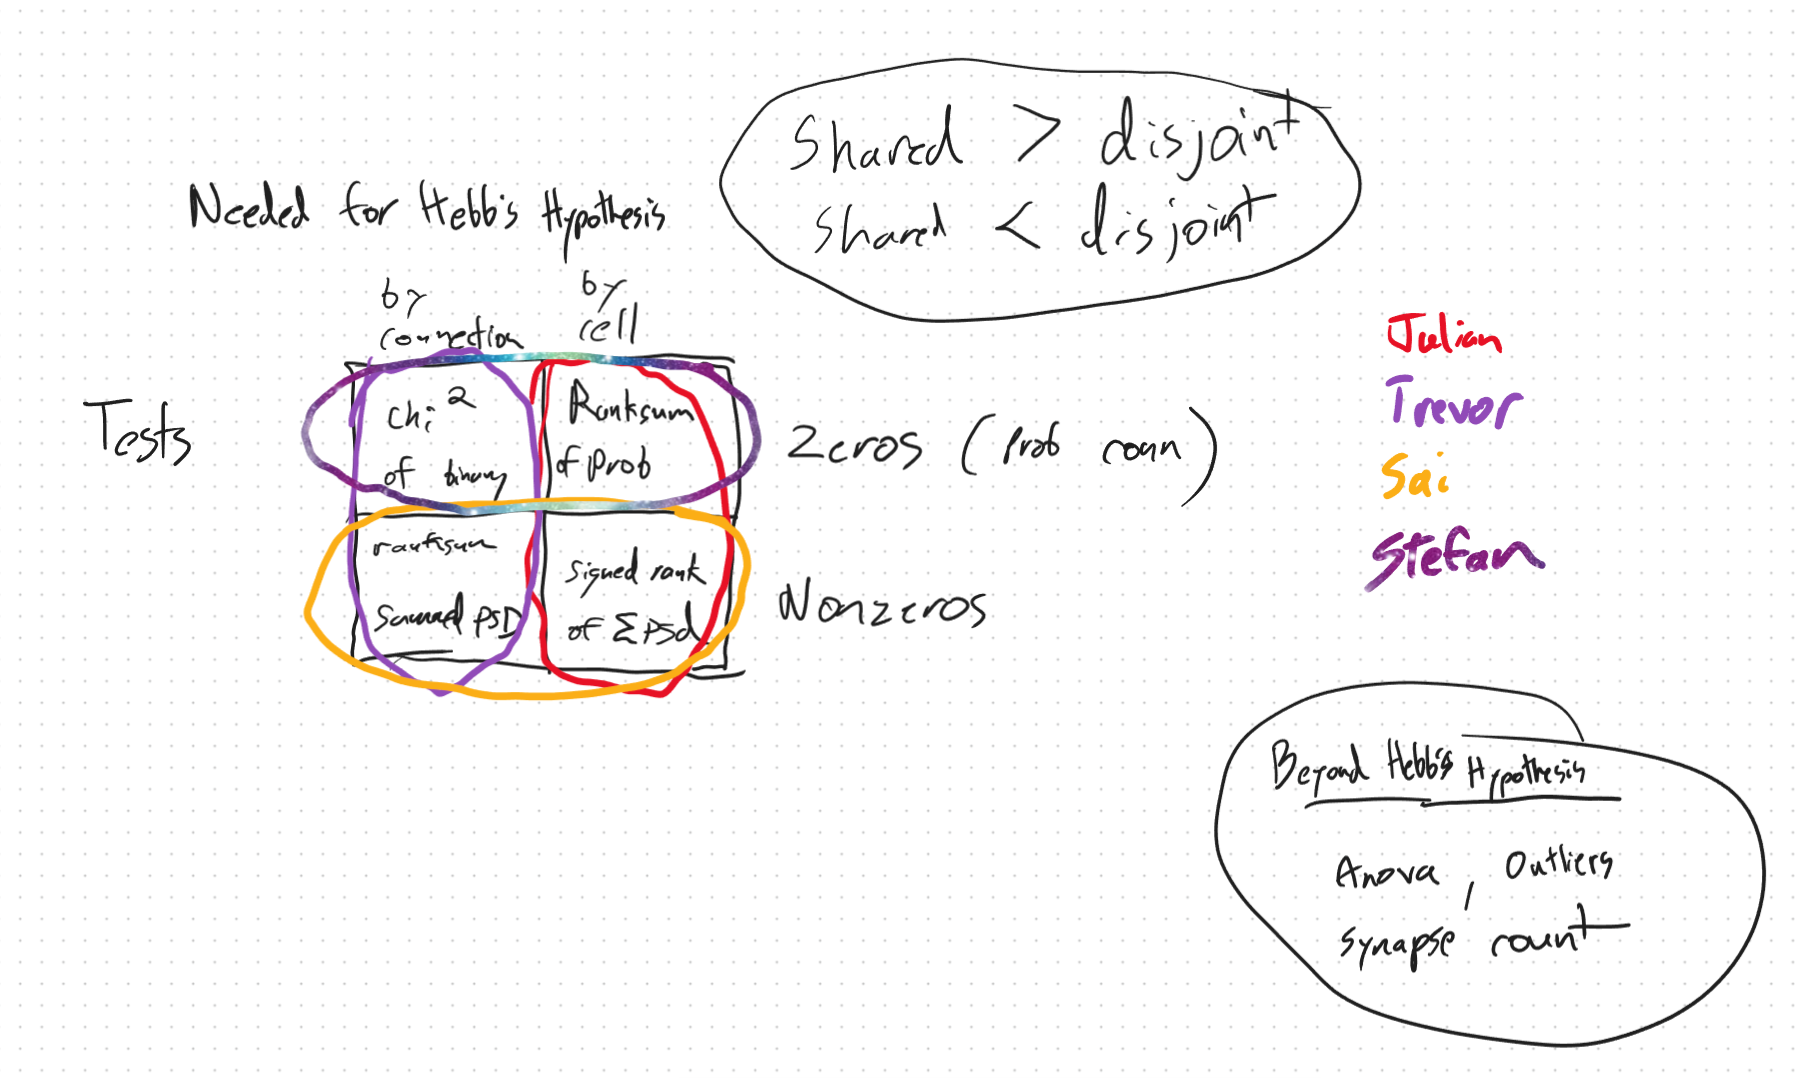

In [5]:
## Chi Squared

import numpy as np
from scipy.stats import chi2_contingency

for c1 in C:
    for c2 in C:
        if c1 != c2:
            print(f'{c1.__name__} vs {c2.__name__} Chi Squared')
            set1 = [v for k, v in b.items() if c1(k[0], k[1], A)]
            set2 = [v for k, v in b.items() if c2(k[0], k[1], A)]

            # Create a contingency table
            contingency_table = np.array([
                [sum(np.array(set1) == 0), sum(np.array(set1) == 1)],
                [sum(np.array(set2) == 0), sum(np.array(set2) == 1)]
            ])

            # Perform the chi-squared test
            chi2_stat, p_val, dof, ex = chi2_contingency(contingency_table)

            print(f"Chi-squared Statistic: {chi2_stat}")
            print(f"P-value: {p_val}")

shared vs disjoint Chi Squared
Chi-squared Statistic: 0.4418834820260927
P-value: 0.5062147769744765
shared vs shared_no_a Chi Squared
Chi-squared Statistic: 0.7092513603796704
P-value: 0.3996924541742918
shared vs no_a_a Chi Squared
Chi-squared Statistic: 1.14079970565214
P-value: 0.28548340910656306
shared vs a_no_a Chi Squared
Chi-squared Statistic: 7.123059964871235
P-value: 0.0076098713524779486
disjoint vs shared Chi Squared
Chi-squared Statistic: 0.4418834820260927
P-value: 0.5062147769744765
disjoint vs shared_no_a Chi Squared
Chi-squared Statistic: 0.18986328953010304
P-value: 0.6630304247984299
disjoint vs no_a_a Chi Squared
Chi-squared Statistic: 0.26176681292738013
P-value: 0.608908920837989
disjoint vs a_no_a Chi Squared
Chi-squared Statistic: 4.819210555059789
P-value: 0.028144232585062278
shared_no_a vs shared Chi Squared
Chi-squared Statistic: 0.7092513603796704
P-value: 0.3996924541742918
shared_no_a vs disjoint Chi Squared
Chi-squared Statistic: 0.18986328953010306
P-



PAIRED SUMMED OUTBOUND BINARY

shared vs disjoint
Greater (shared > disjoint):
WilcoxonResult(statistic=295.0, pvalue=0.5170476729160017)

disjoint vs shared
Greater (disjoint > shared):
WilcoxonResult(statistic=300.0, pvalue=0.4829523270839982)


Text(0.5, 1.0, 'PAIRED SUMMED OUTBOUND BINARY: disjoint vs shared')

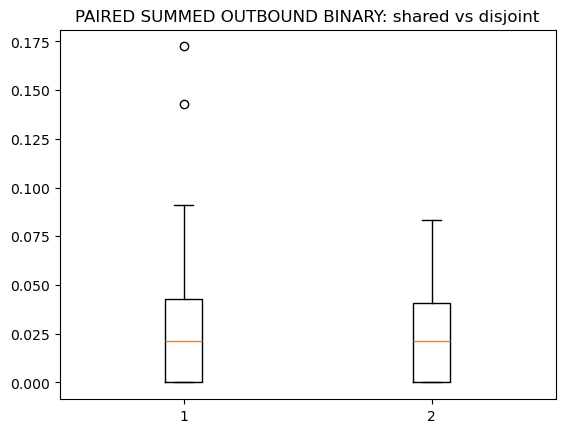

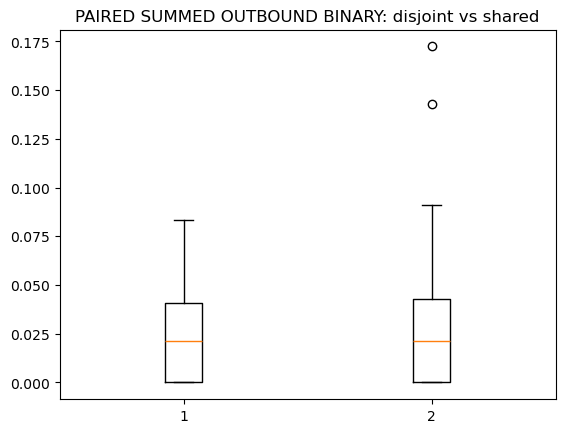

In [6]:
## Paired Outbound Summed Binary

print('\n\nPAIRED SUMMED OUTBOUND BINARY')
c1 = C[0]
c2 = C[1]
        
print(f'\n{c1.__name__} vs {c2.__name__}')
result = stats.wilcoxon(list(B_out_paired[c1.__name__].values()), list(B_out_paired[c2.__name__].values()), alternative='greater')
# if result.pvalue < 0.05:
print(f'Greater ({c1.__name__} > {c2.__name__}):')
print(result)
plt.figure()
plt.boxplot([list(B_out_paired[c1.__name__].values()), list(B_out_paired[c2.__name__].values())])
plt.title(f'PAIRED SUMMED OUTBOUND BINARY: {c1.__name__} vs {c2.__name__}')

print(f'\n{c2.__name__} vs {c1.__name__}')
result = stats.wilcoxon(list(B_out_paired[c2.__name__].values()), list(B_out_paired[c1.__name__].values()), alternative='greater')
# if result.pvalue < 0.05:
print(f'Greater ({c2.__name__} > {c1.__name__}):')
print(result)
plt.figure()
plt.boxplot([list(B_out_paired[c2.__name__].values()), list(B_out_paired[c1.__name__].values())])
plt.title(f'PAIRED SUMMED OUTBOUND BINARY: {c2.__name__} vs {c1.__name__}')




SUMMED OUTBOUND BINARY

shared vs disjoint

shared vs shared_no_a

shared vs no_a_a

shared vs a_no_a

disjoint vs shared

disjoint vs shared_no_a

disjoint vs no_a_a

disjoint vs a_no_a
Greater:
RanksumsResult(statistic=2.129018644681083, pvalue=0.016626358931995596)

shared_no_a vs shared

shared_no_a vs disjoint

shared_no_a vs no_a_a

shared_no_a vs a_no_a

no_a_a vs shared

no_a_a vs disjoint

no_a_a vs shared_no_a

no_a_a vs a_no_a

a_no_a vs shared

a_no_a vs disjoint

a_no_a vs shared_no_a

a_no_a vs no_a_a


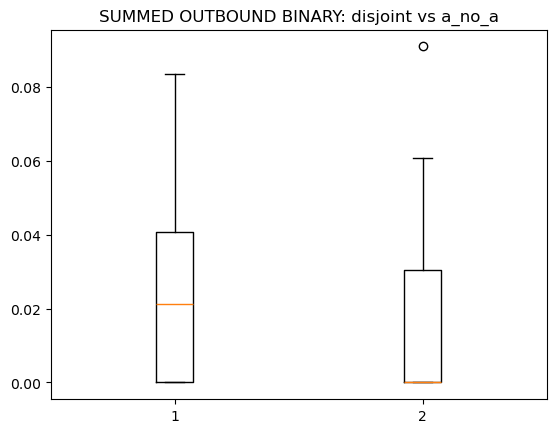

In [18]:

## Outbound Summed Binary

print('\n\nSUMMED OUTBOUND BINARY')
for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
            result = stats.ranksums(list(B_out[c1.__name__].values()), list(B_out[c2.__name__].values()), alternative='greater')
            if result.pvalue < 0.05:
                print('Greater:')
                print(result)
                plt.figure()
                plt.boxplot([list(B_out[c1.__name__].values()), list(B_out[c2.__name__].values())])
                plt.title(f'SUMMED OUTBOUND BINARY: {c1.__name__} vs {c2.__name__}')




PAIRED NONZERO SUMMED OUTBOUND SUMMED PSD VOLUME

shared vs disjoint
14 14
Greater (shared > disjoint):
WilcoxonResult(statistic=32.0, pvalue=0.90313720703125)

disjoint vs shared
Greater (disjoint > shared):
WilcoxonResult(statistic=73.0, pvalue=0.1082763671875)


Text(0.5, 1.0, 'PAIRED NONZERO SUMMED OUTBOUND SUMMED PSD VOLUME: disjoint vs shared')

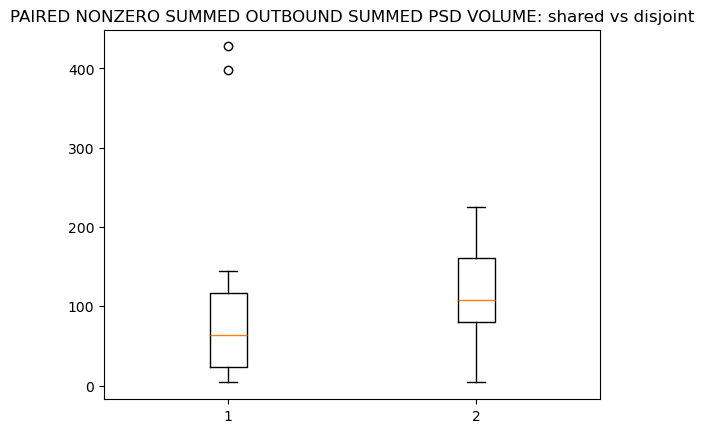

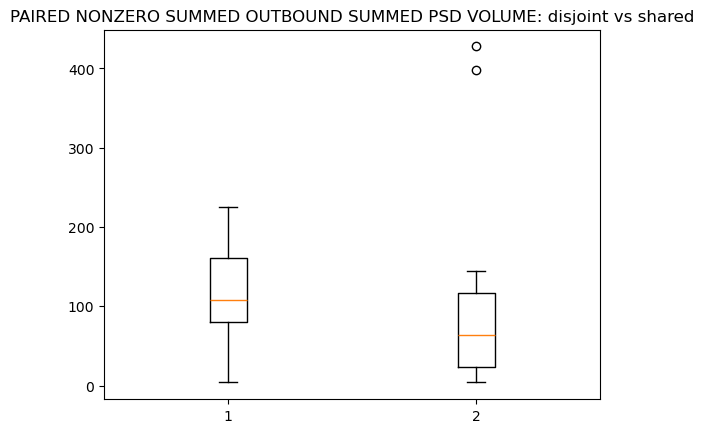

In [19]:
## Paired Outbound Summed Binary
print('\n\nPAIRED NONZERO SUMMED OUTBOUND SUMMED PSD VOLUME')
c1 = C[0]
c2 = C[1]

print(f'\n{c1.__name__} vs {c2.__name__}')
print(len(W_out_paired[c1.__name__].values()), len(W_out_paired[c2.__name__].values()))
result = stats.wilcoxon(list(W_out_paired[c1.__name__].values()), list(W_out_paired[c2.__name__].values()), alternative='greater')
# if result.pvalue < 0.05:
print(f'Greater ({c1.__name__} > {c2.__name__}):')
print(result)
plt.figure()
plt.boxplot([list(W_out_paired[c1.__name__].values()), list(W_out_paired[c2.__name__].values())])
plt.title(f'PAIRED NONZERO SUMMED OUTBOUND SUMMED PSD VOLUME: {c1.__name__} vs {c2.__name__}')

print(f'\n{c2.__name__} vs {c1.__name__}')
result = stats.wilcoxon(list(W_out_paired[c2.__name__].values()), list(W_out_paired[c1.__name__].values()), alternative='greater')
# if result.pvalue < 0.05:
print(f'Greater ({c2.__name__} > {c1.__name__}):')
print(result)
plt.figure()
plt.boxplot([list(W_out_paired[c2.__name__].values()), list(W_out_paired[c1.__name__].values())])
plt.title(f'PAIRED NONZERO SUMMED OUTBOUND SUMMED PSD VOLUME: {c2.__name__} vs {c1.__name__}')




SUMMED OUTBOUND SUMMED PSDS

shared vs disjoint
Greater:
RanksumsResult(statistic=-0.7735086889491162, pvalue=0.7803893057618678)

shared vs shared_no_a
Greater:
RanksumsResult(statistic=0.6658003028611832, pvalue=0.25276937564182045)

shared vs no_a_a
Greater:
RanksumsResult(statistic=-0.7282190812544191, pvalue=0.7667602564373761)

shared vs a_no_a
Greater:
RanksumsResult(statistic=1.388799691522277, pvalue=0.08244683454577556)

disjoint vs shared
Greater:
RanksumsResult(statistic=0.7735086889491162, pvalue=0.21961069423813223)

disjoint vs shared_no_a
Greater:
RanksumsResult(statistic=1.09024860769371, pvalue=0.13780182341574698)

disjoint vs no_a_a
Greater:
RanksumsResult(statistic=-0.06113543594544168, pvalue=0.524374325941958)

disjoint vs a_no_a
Greater:
RanksumsResult(statistic=2.2628920280180274, pvalue=0.011821172974310797)

shared_no_a vs shared
Greater:
RanksumsResult(statistic=-0.6658003028611832, pvalue=0.7472306243581796)

shared_no_a vs disjoint
Greater:
RanksumsResul


shared_no_a vs a_no_a
Greater:
RanksumsResult(statistic=0.2751094617544876, pvalue=0.3916160712669184)

no_a_a vs shared
Greater:
RanksumsResult(statistic=0.7282190812544191, pvalue=0.23323974356262384)

no_a_a vs disjoint
Greater:
RanksumsResult(statistic=0.06113543594544168, pvalue=0.47562567405804207)

no_a_a vs shared_no_a
Greater:
RanksumsResult(statistic=1.1547005383792515, pvalue=0.12410653949496186)

no_a_a vs a_no_a
Greater:
RanksumsResult(statistic=2.0582263434965364, pvalue=0.019784205462226305)

a_no_a vs shared
Greater:
RanksumsResult(statistic=-1.388799691522277, pvalue=0.9175531654542244)

a_no_a vs disjoint
Greater:
RanksumsResult(statistic=-2.2628920280180274, pvalue=0.9881788270256892)

a_no_a vs shared_no_a
Greater:
RanksumsResult(statistic=-0.2751094617544876, pvalue=0.6083839287330817)

a_no_a vs no_a_a
Greater:
RanksumsResult(statistic=-2.0582263434965364, pvalue=0.9802157945377737)


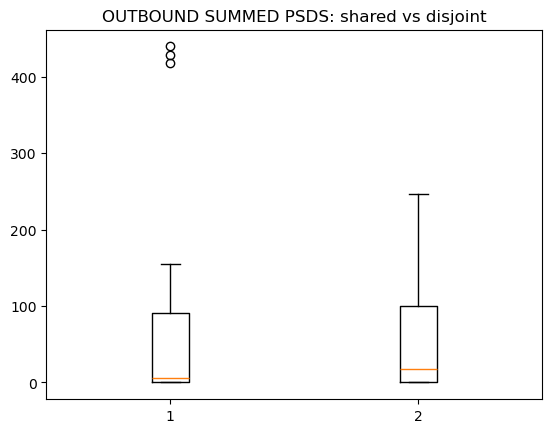

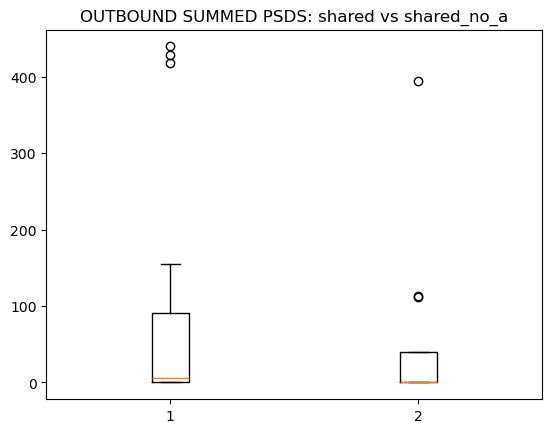

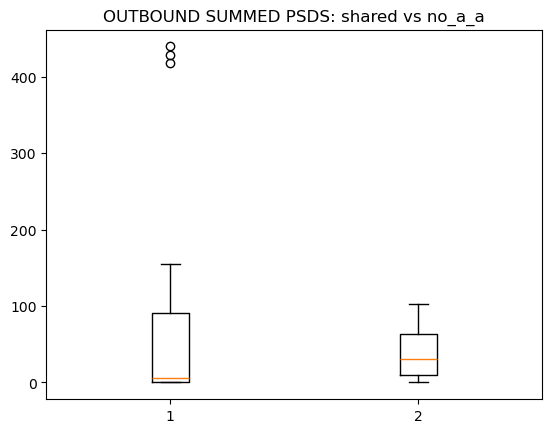

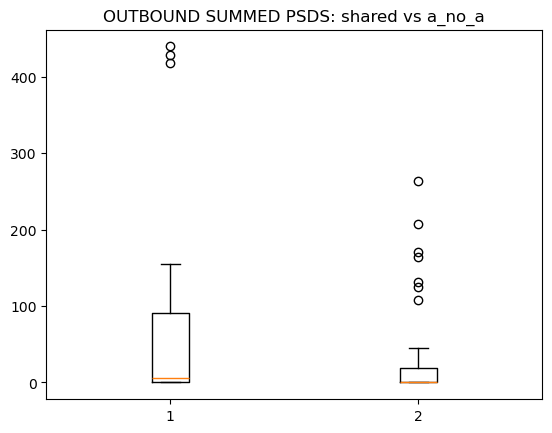

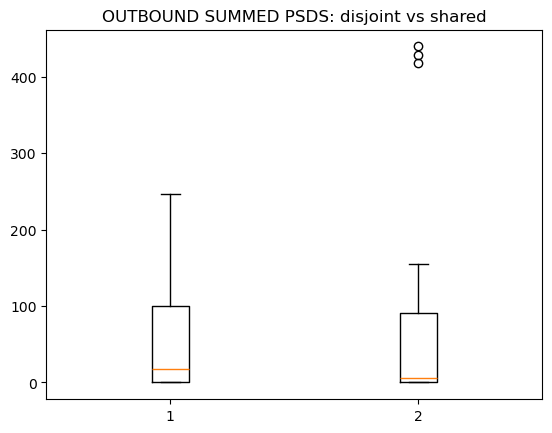

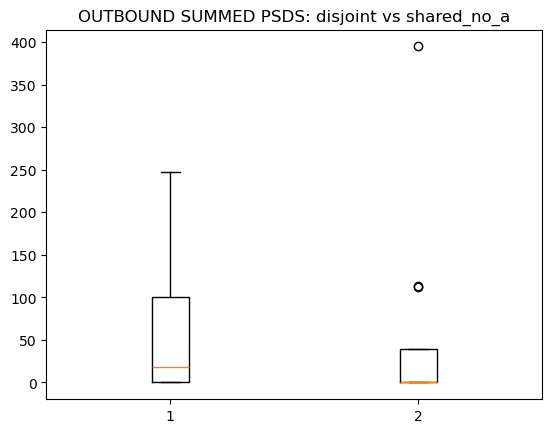

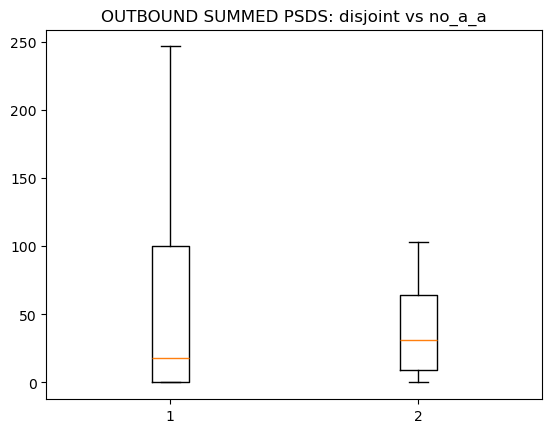

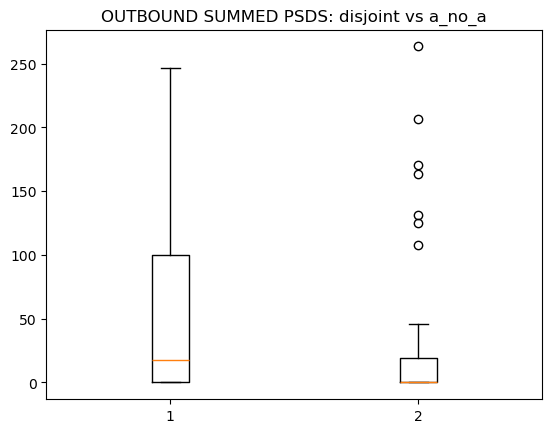

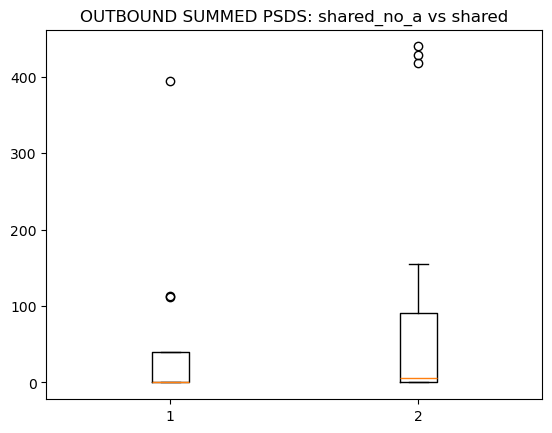

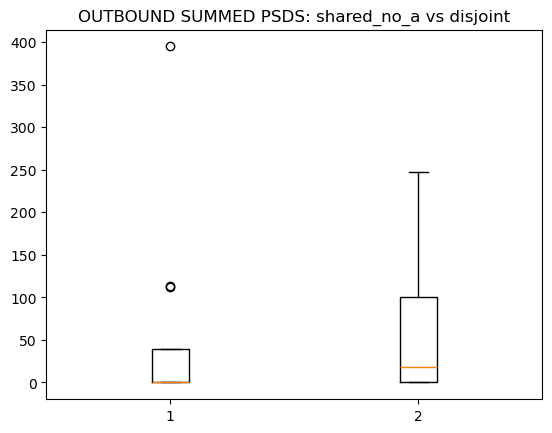

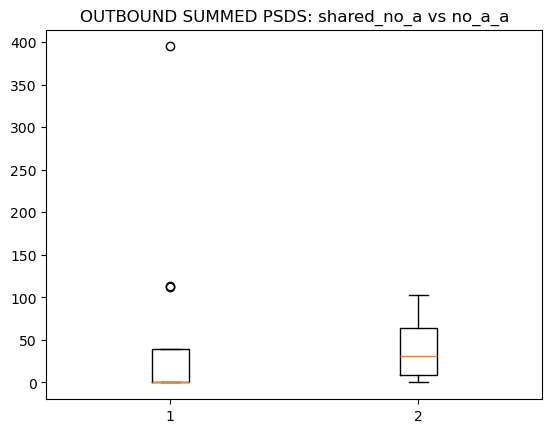

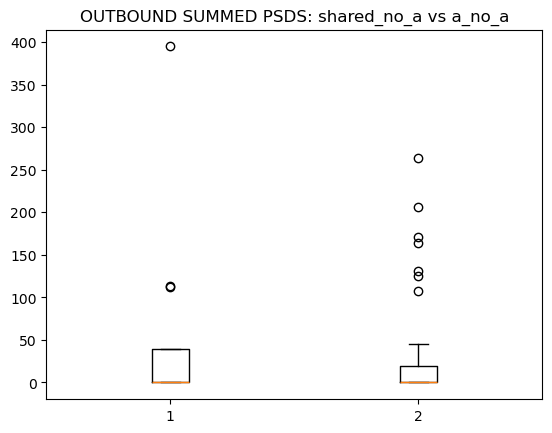

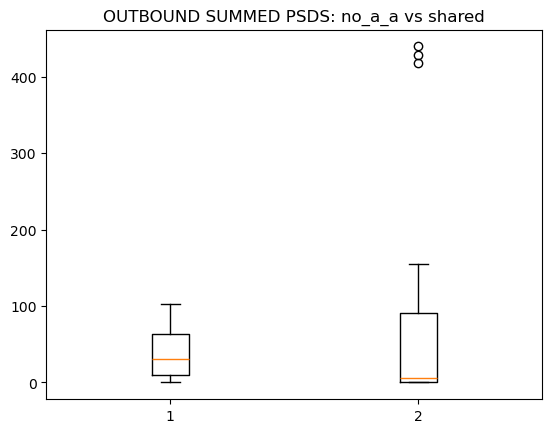

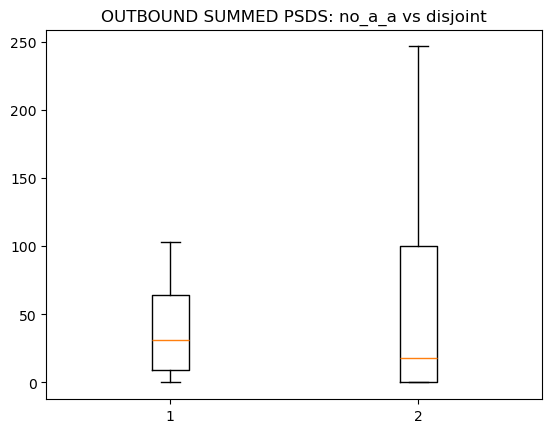

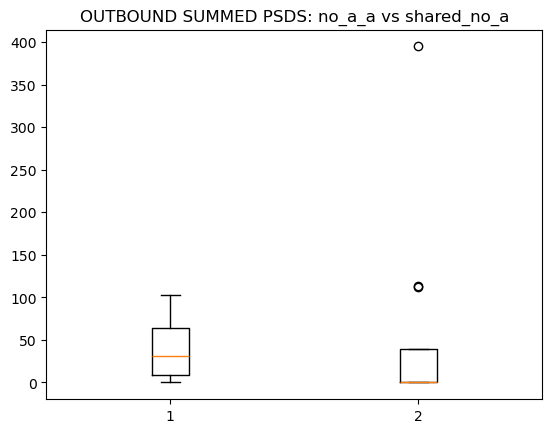

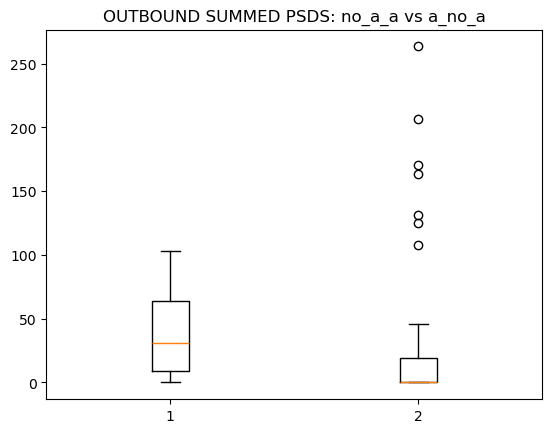

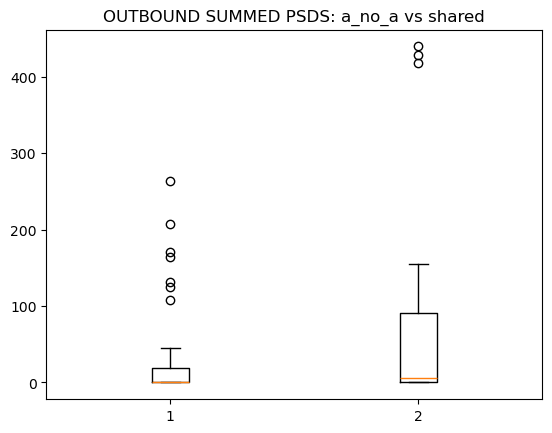

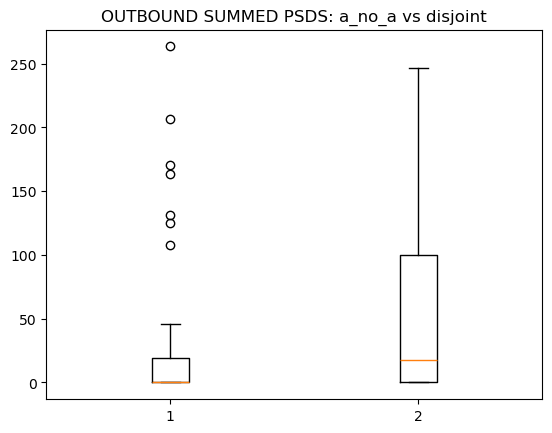

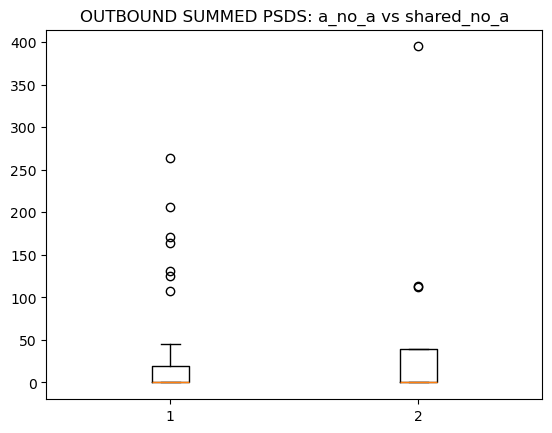

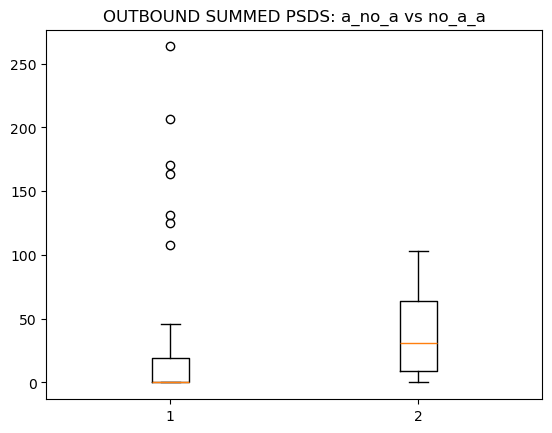

In [9]:
# Outbound Summed PSDs

print('\n\nSUMMED OUTBOUND SUMMED PSDS')
for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
            result = stats.ranksums(list(W_out[c1.__name__].values()), list(W_out[c2.__name__].values()), alternative='greater')
            # if result.pvalue < 0.05:
            print('Greater:')
            print(result)
            plt.figure()
            plt.boxplot([list(W_out[c1.__name__].values()), list(W_out[c2.__name__].values())])
            plt.title(f'OUTBOUND SUMMED PSDS: {c1.__name__} vs {c2.__name__}')




NONZERO SUMMED OUTBOUND SUMMED PSDS

shared vs disjoint
Greater:
RanksumsResult(statistic=0.5276900958710203, pvalue=0.29885722425362904) 22 28

shared vs shared_no_a
Greater:
RanksumsResult(statistic=0.3120938919661796, pvalue=0.37748458418804565) 22 5

shared vs no_a_a
Greater:
RanksumsResult(statistic=1.7481986005907446, pvalue=0.04021482192502468) 22 10

shared vs a_no_a
Greater:
RanksumsResult(statistic=0.6208780157885367, pvalue=0.26733994344619116) 22 16

disjoint vs shared
Greater:
RanksumsResult(statistic=-0.5276900958710203, pvalue=0.701142775746371) 28 22

disjoint vs shared_no_a
Greater:
RanksumsResult(statistic=-0.35146751167740364, pvalue=0.6373811791732258) 28 5

disjoint vs no_a_a
Greater:
RanksumsResult(statistic=1.458585797089951, pvalue=0.07233957253403354) 28 10

disjoint vs a_no_a
Greater:
RanksumsResult(statistic=0.09759000729485333, pvalue=0.46112892982603093) 28 16

shared_no_a vs shared
Greater:
RanksumsResult(statistic=-0.3120938919661796, pvalue=0.622515415


shared_no_a vs a_no_a
Greater:
RanksumsResult(statistic=0.1651445647689541, pvalue=0.43441509846265686) 5 16

no_a_a vs shared
Greater:
RanksumsResult(statistic=-1.7481986005907446, pvalue=0.9597851780749753) 10 22

no_a_a vs disjoint
Greater:
RanksumsResult(statistic=-1.458585797089951, pvalue=0.9276604274659664) 10 28

no_a_a vs shared_no_a
Greater:
RanksumsResult(statistic=-1.224744871391589, pvalue=0.8896643190400766) 10 5

no_a_a vs a_no_a
Greater:
RanksumsResult(statistic=-0.9486832980505138, pvalue=0.8286091444260443) 10 16

a_no_a vs shared
Greater:
RanksumsResult(statistic=-0.6208780157885367, pvalue=0.7326600565538088) 16 22

a_no_a vs disjoint
Greater:
RanksumsResult(statistic=-0.09759000729485333, pvalue=0.5388710701739691) 16 28

a_no_a vs shared_no_a
Greater:
RanksumsResult(statistic=-0.1651445647689541, pvalue=0.5655849015373431) 16 5

a_no_a vs no_a_a
Greater:
RanksumsResult(statistic=0.9486832980505138, pvalue=0.17139085557395572) 16 10


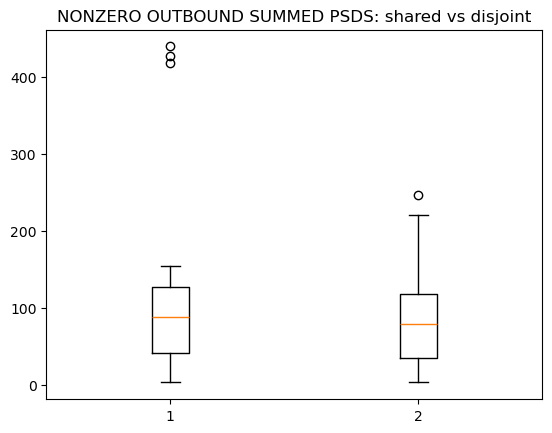

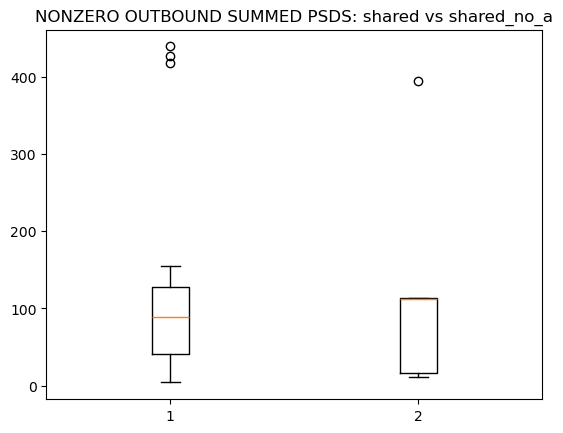

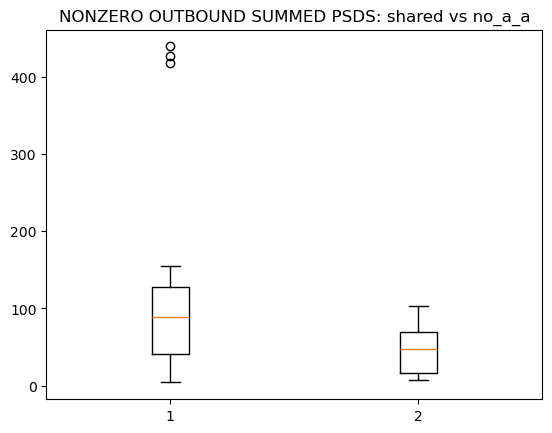

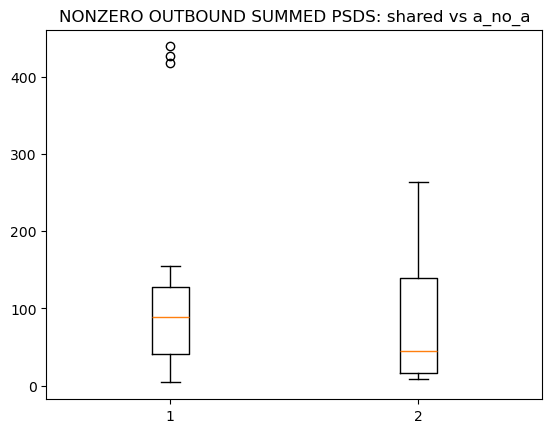

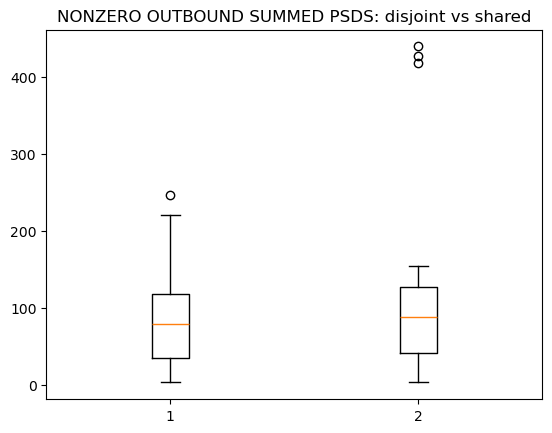

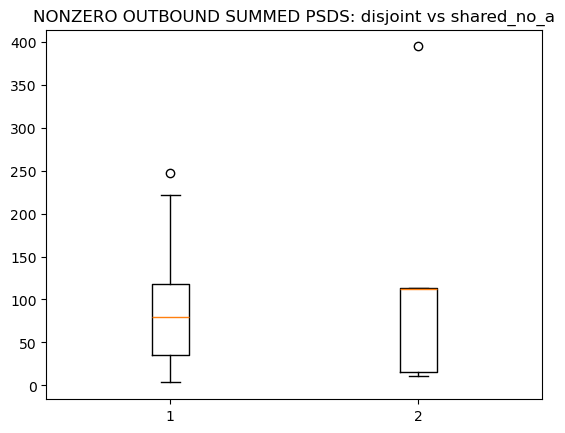

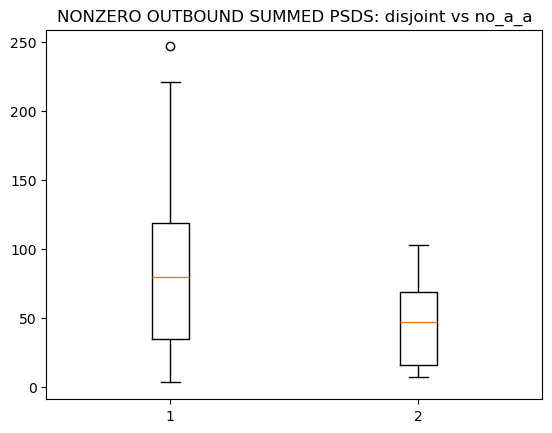

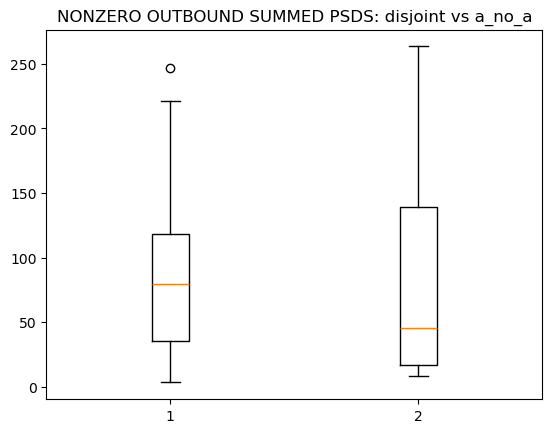

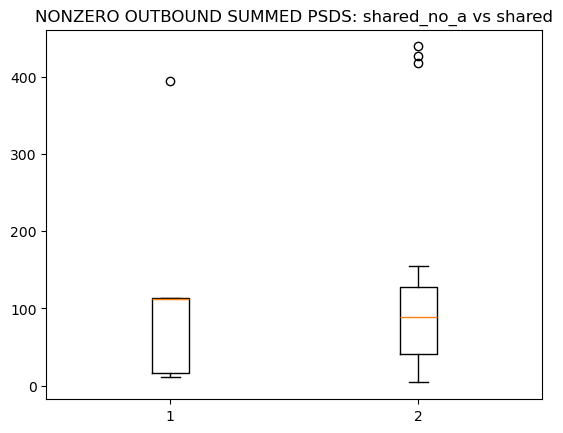

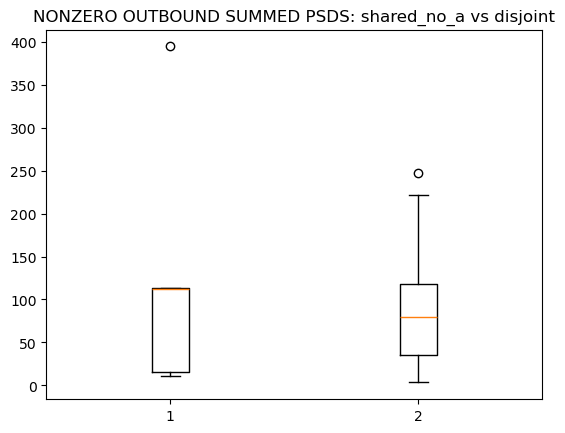

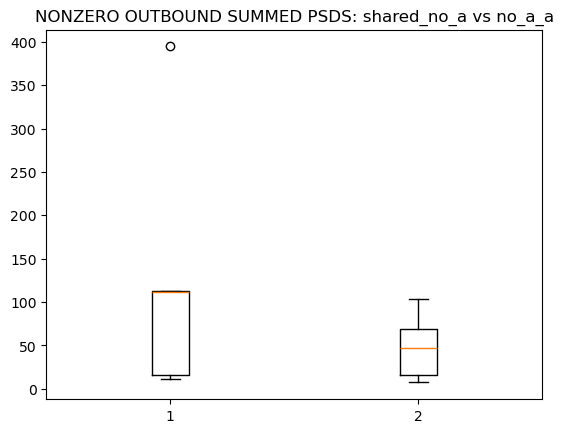

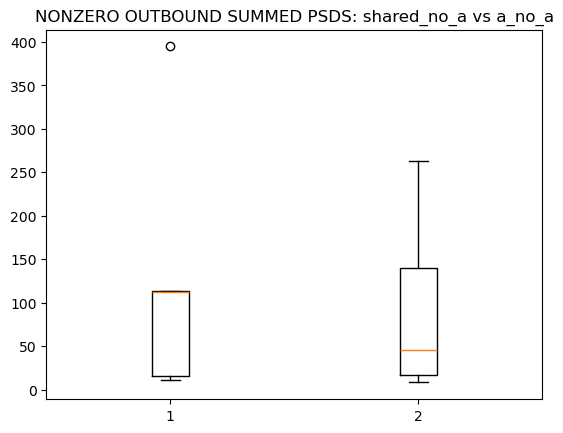

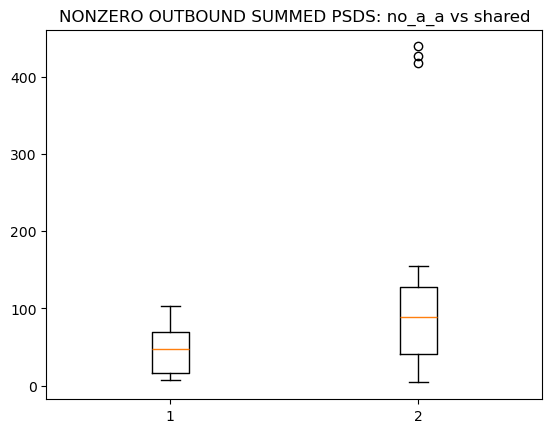

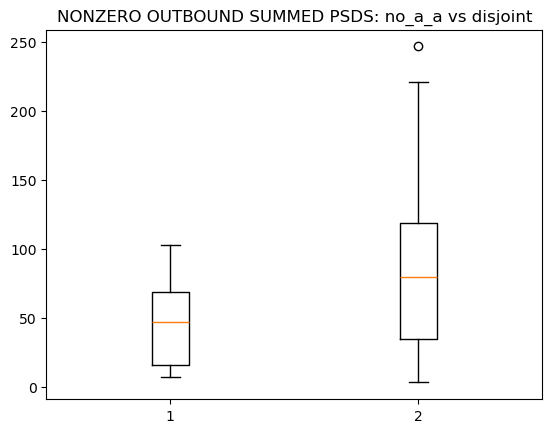

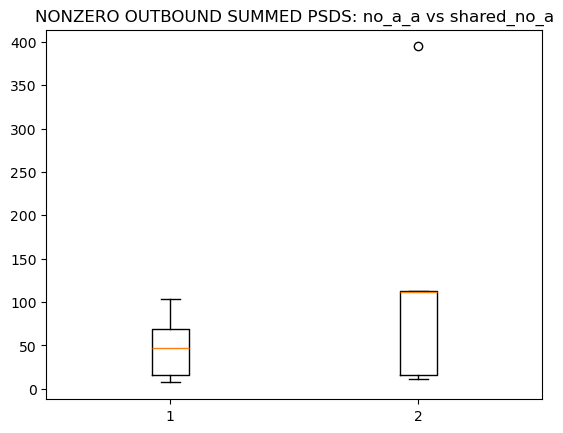

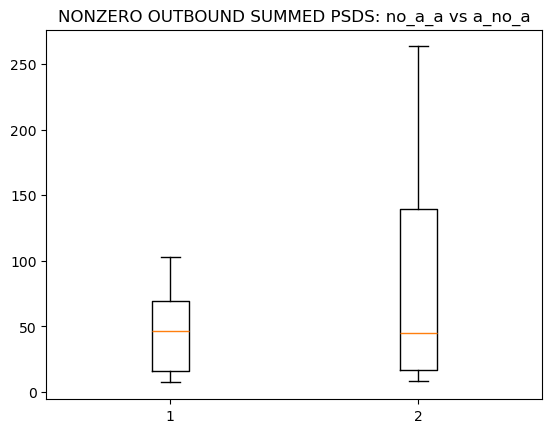

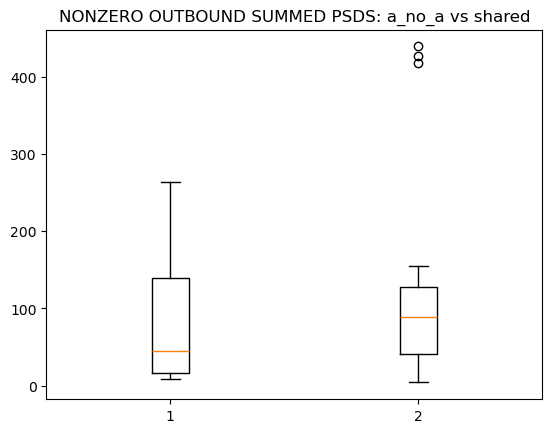

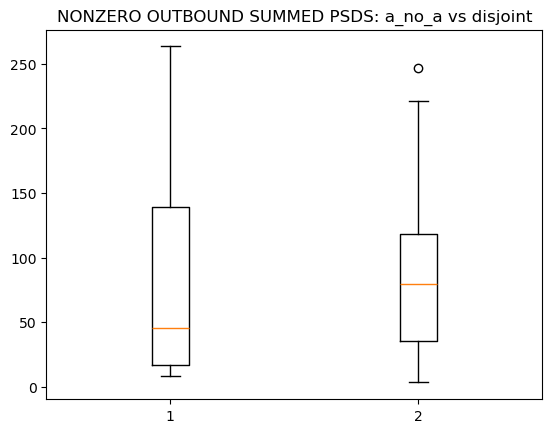

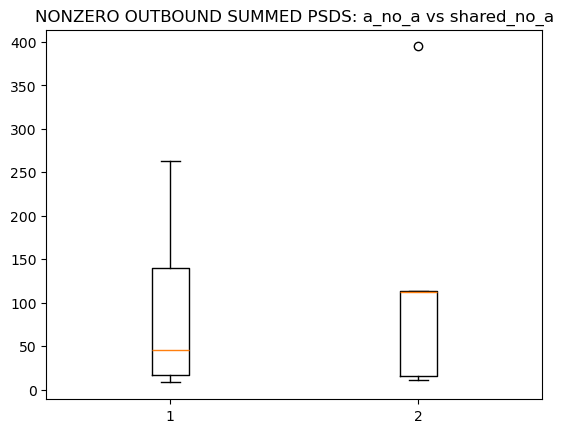

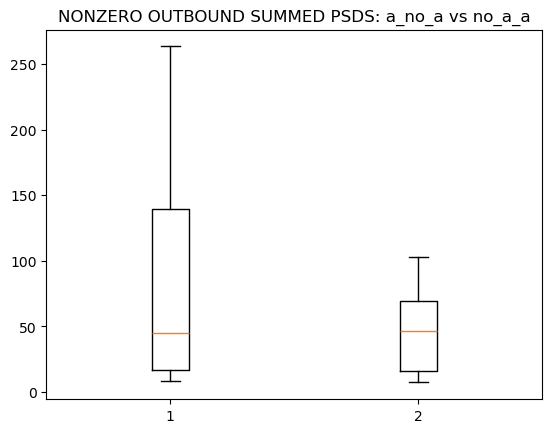

In [10]:
# Nonzero Outbound Summed PSDs

print('\n\nNONZERO SUMMED OUTBOUND SUMMED PSDS')
for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
            # print(len(np.array(W_out[c1.__name__].values()).nonzero()[0]), len(np.aray(W_out[c2.__name__].values()).nonzero()[0]))
            c1_set = np.array(list(W_out[c1.__name__].values()))[np.array(list(W_out[c1.__name__].values())).nonzero()[0]]
            c2_set = np.array(list(W_out[c2.__name__].values()))[np.array(list(W_out[c2.__name__].values())).nonzero()[0]]
            result = stats.ranksums(c1_set, c2_set, alternative='greater')
            # if result.pvalue < 0.05:
            print('Greater:')
            print(result, len(c1_set), len(c2_set))
            plt.figure()
            plt.boxplot([c1_set, c2_set])
            plt.title(f'NONZERO OUTBOUND SUMMED PSDS: {c1.__name__} vs {c2.__name__}')




INBOUND SUMMED PSDS

shared vs disjoint

shared vs shared_no_a

shared vs no_a_a

shared vs a_no_a

disjoint vs shared

disjoint vs shared_no_a

disjoint vs no_a_a
Greater:
RanksumsResult(statistic=2.126061116140648, pvalue=0.016749085520890602)

disjoint vs a_no_a

shared_no_a vs shared

shared_no_a vs disjoint

shared_no_a vs no_a_a

shared_no_a vs a_no_a

no_a_a vs shared

no_a_a vs disjoint

no_a_a vs shared_no_a

no_a_a vs a_no_a

a_no_a vs shared

a_no_a vs disjoint

a_no_a vs shared_no_a

a_no_a vs no_a_a


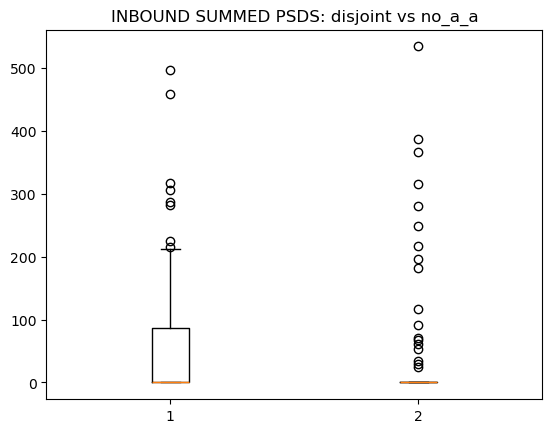

In [11]:
# Inbound Statistical tests

print('\n\nINBOUND SUMMED PSDS')

for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
            result = stats.ranksums(list(W_in[c1.__name__].values()), list(W_in[c2.__name__].values()), alternative='greater')
            if result.pvalue < 0.05:
                print('Greater:')
                print(result)
                plt.figure()
                plt.boxplot([list(W_in[c1.__name__].values()), list(W_in[c2.__name__].values())])
                plt.title(f'INBOUND SUMMED PSDS: {c1.__name__} vs {c2.__name__}')



NONZERO INBOUND SUMMED PSDS

shared vs disjoint
Greater:
RanksumsResult(statistic=1.3749369536407838, pvalue=0.08457549573391526)

shared vs shared_no_a
Greater:
RanksumsResult(statistic=-0.9561619330196536, pvalue=0.8305047855695243)

shared vs no_a_a
Greater:
RanksumsResult(statistic=-0.07881104062391008, pvalue=0.5314085388915315)

shared vs a_no_a
Greater:
RanksumsResult(statistic=2.2230945790422183, pvalue=0.013104711559230231)

disjoint vs shared
Greater:
RanksumsResult(statistic=-1.3749369536407838, pvalue=0.9154245042660847)

disjoint vs shared_no_a
Greater:
RanksumsResult(statistic=-1.5356235003684078, pvalue=0.9376846264615224)

disjoint vs no_a_a
Greater:
RanksumsResult(statistic=-1.0705287226561209, pvalue=0.8578093062721242)

disjoint vs a_no_a
Greater:
RanksumsResult(statistic=1.2411968556386153, pvalue=0.10726651806648979)

shared_no_a vs shared
Greater:
RanksumsResult(statistic=0.9561619330196536, pvalue=0.16949521443047566)

shared_no_a vs disjoint
Greater:
RanksumsR

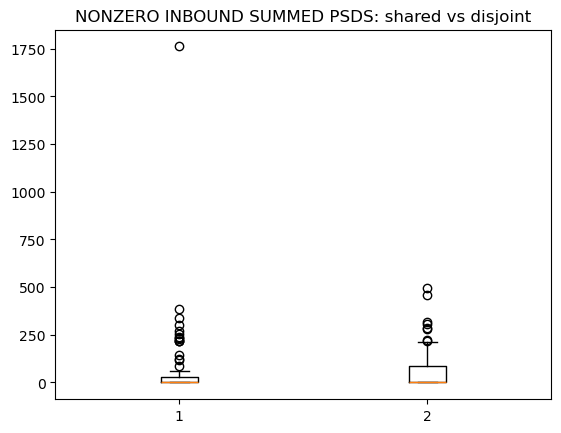

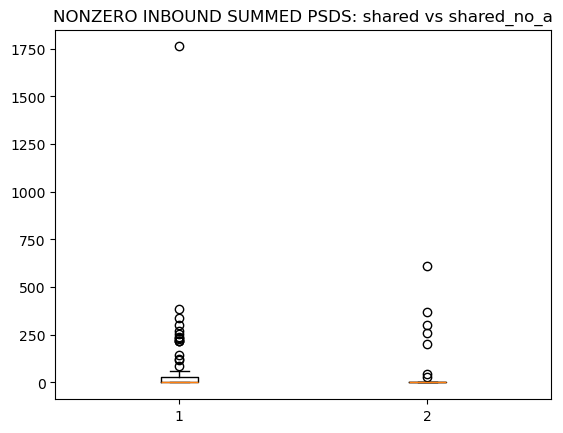

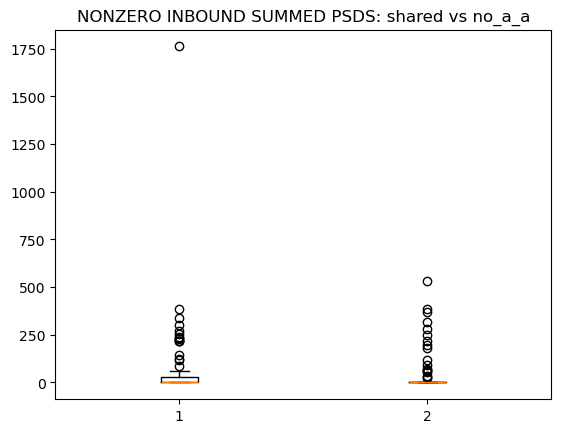

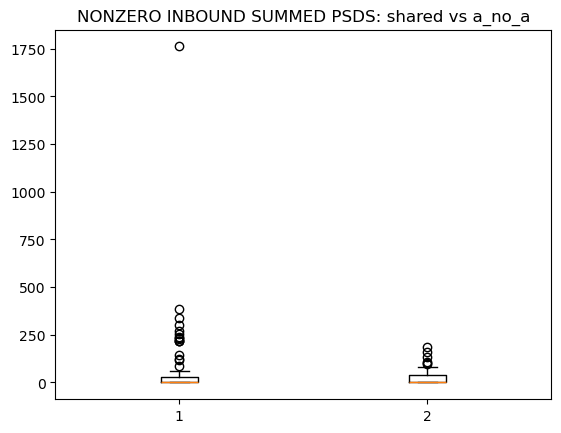

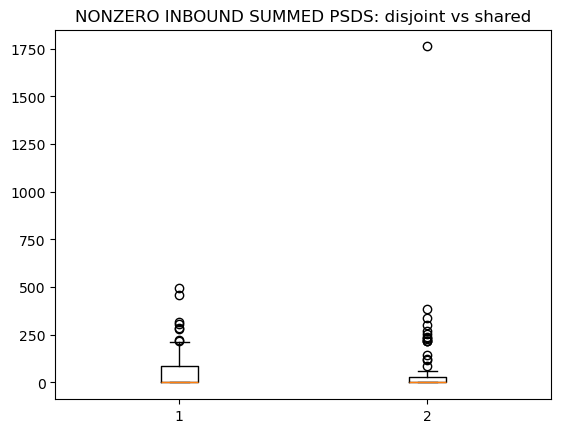

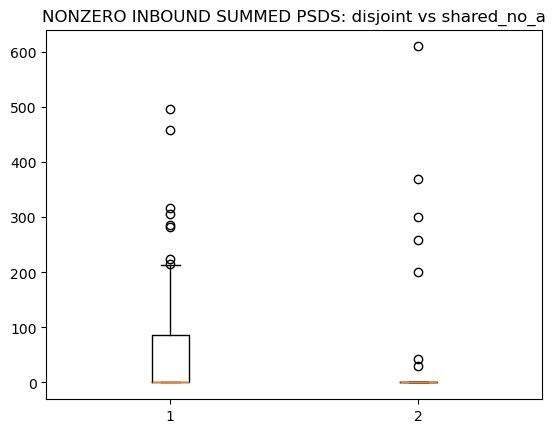

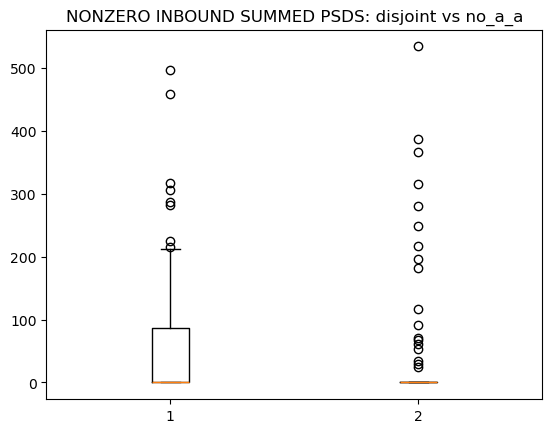

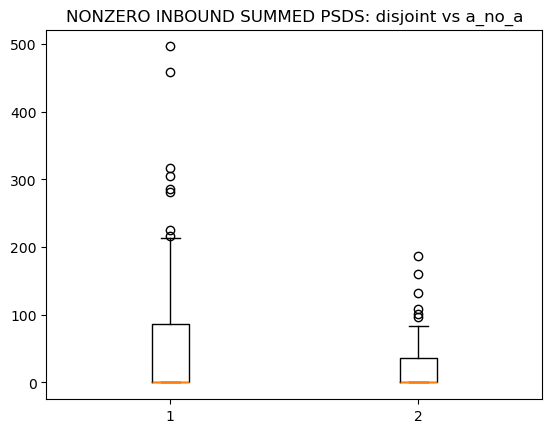

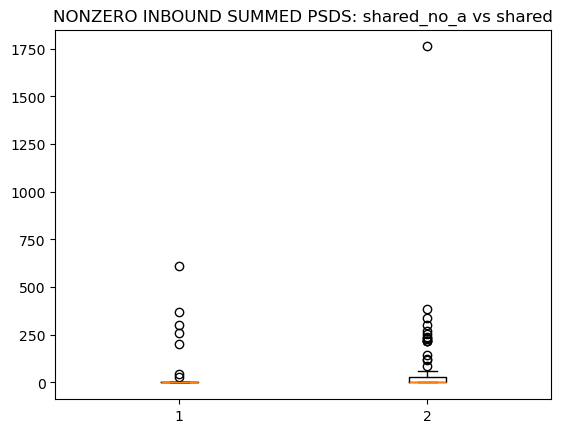

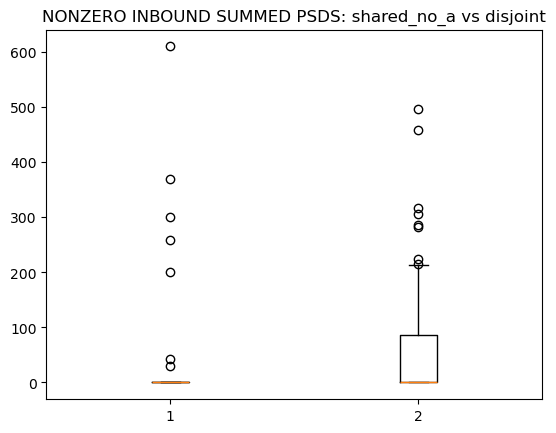

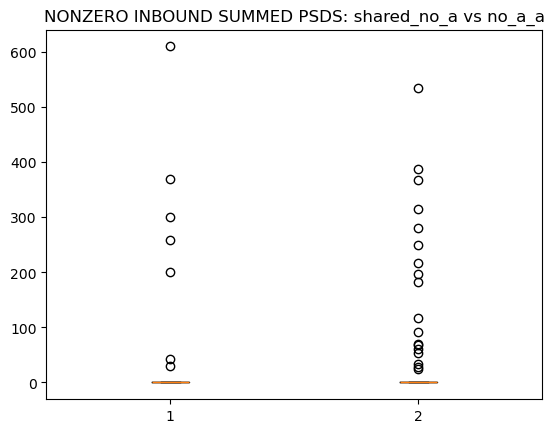

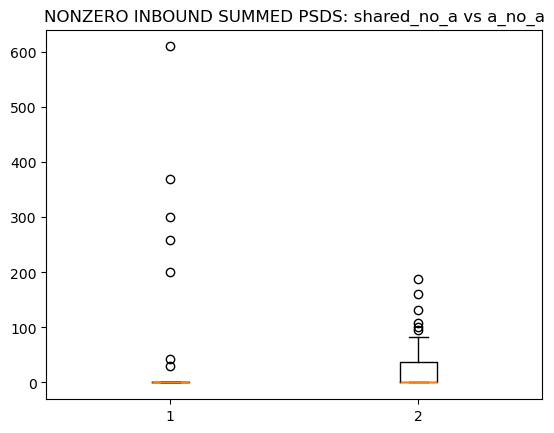

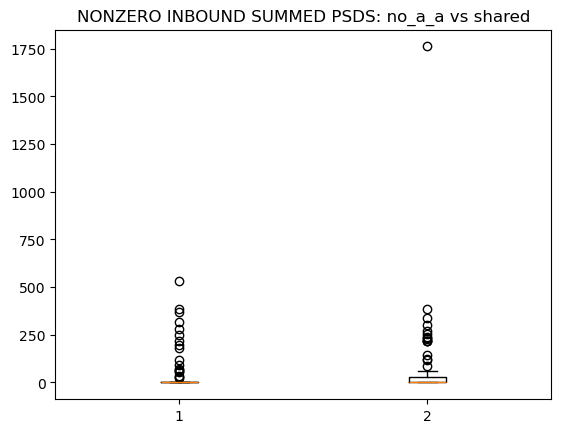

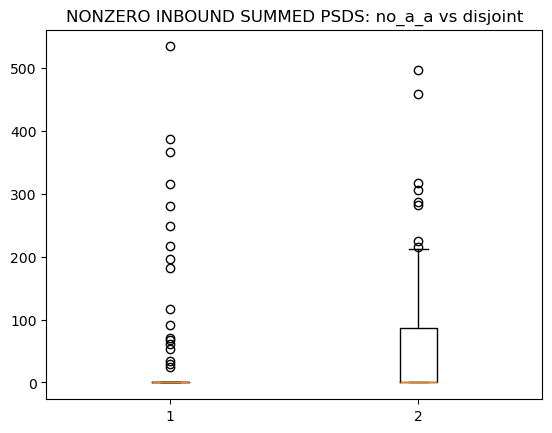

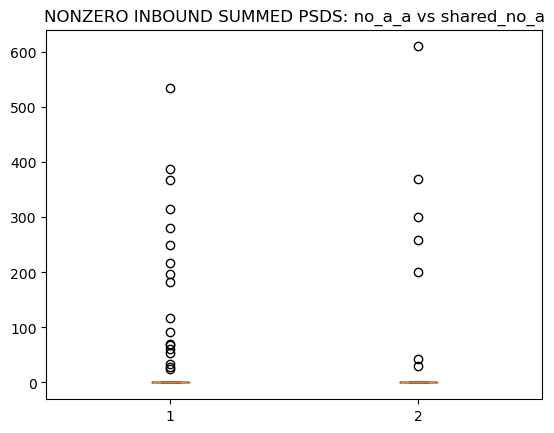

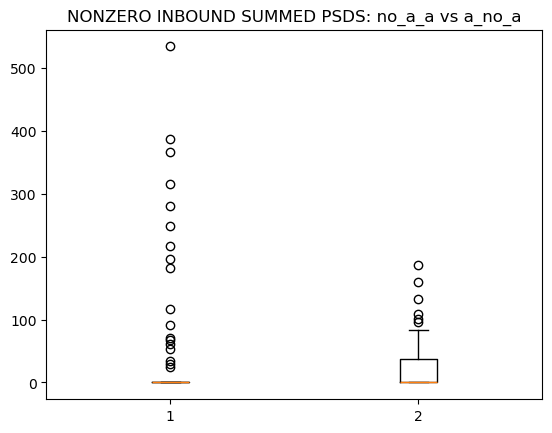

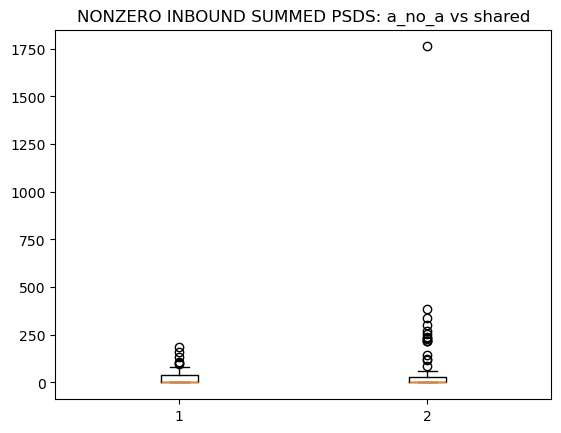

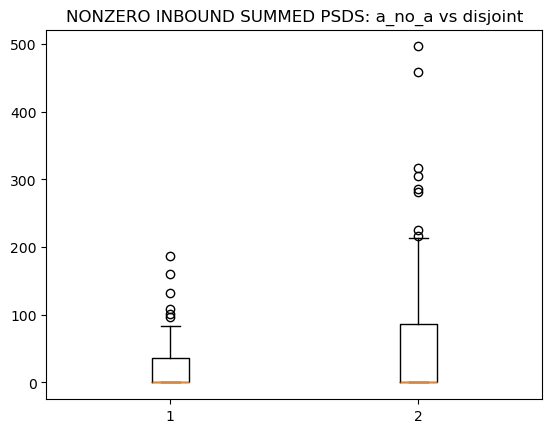

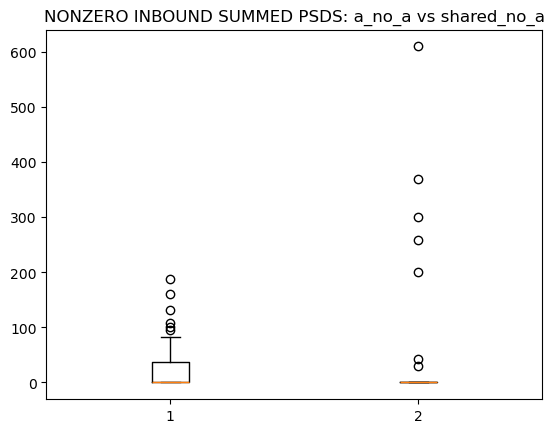

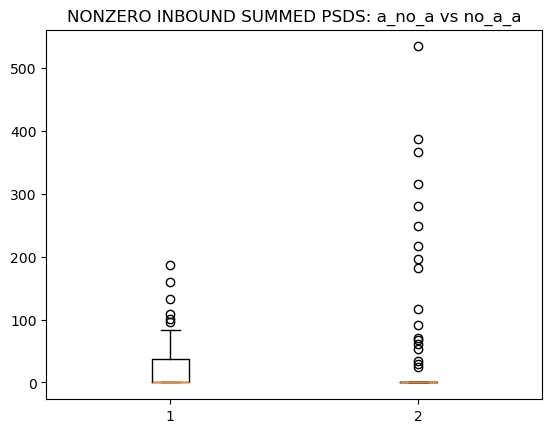

In [22]:
# Inbound Statistical tests

print('\n\nNONZERO INBOUND SUMMED PSDS')

for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
            c1_set = np.array(list(W_in[c1.__name__].values()))[np.array(list(W_in[c1.__name__].values())).nonzero()[0]]
            c2_set = np.array(list(W_in[c2.__name__].values()))[np.array(list(W_in[c2.__name__].values())).nonzero()[0]]
            result = stats.ranksums(c1_set, c2_set, alternative='greater')
            # if result.pvalue < 0.05:
            print('Greater:')
            print(result)
            plt.figure()
            plt.boxplot([list(W_in[c1.__name__].values()), list(W_in[c2.__name__].values())])
            plt.title(f'NONZERO INBOUND SUMMED PSDS: {c1.__name__} vs {c2.__name__}')



OUTBOUND SYNAPSE COUNT

shared vs disjoint

shared vs shared_no_a

shared vs no_a_a

shared vs a_no_a

disjoint vs shared

disjoint vs shared_no_a

disjoint vs no_a_a

disjoint vs a_no_a
Greater:
RanksumsResult(statistic=2.1462926296277853, pvalue=0.01592481963059077)

shared_no_a vs shared

shared_no_a vs disjoint

shared_no_a vs no_a_a

shared_no_a vs a_no_a

no_a_a vs shared

no_a_a vs disjoint

no_a_a vs shared_no_a

no_a_a vs a_no_a

a_no_a vs shared

a_no_a vs disjoint

a_no_a vs shared_no_a

a_no_a vs no_a_a


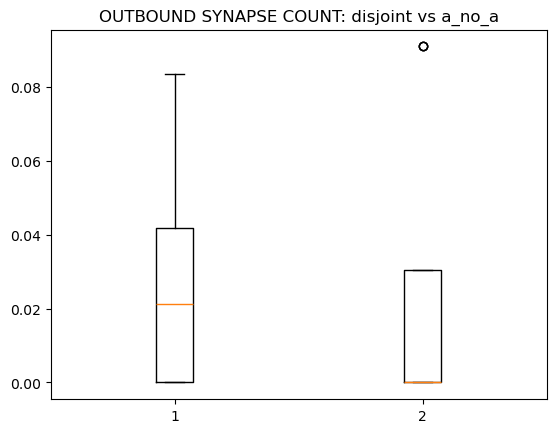

In [12]:
# Outbound Synapse Count Statistical tests

print('\n\nOUTBOUND SYNAPSE COUNT')

for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
            result = stats.ranksums(list(S_out[c1.__name__].values()), list(S_out[c2.__name__].values()), alternative='greater')
            if result.pvalue < 0.05:
                print('Greater:')
                print(result)
                plt.figure()
                plt.boxplot([list(S_out[c1.__name__].values()), list(S_out[c2.__name__].values())])
                plt.title(f'OUTBOUND SYNAPSE COUNT: {c1.__name__} vs {c2.__name__}')
            # print('Greater:')
            # print()
            # plt.figure()
            # plt.boxplot([list(S_out[c1.__name__].values()), list(S_out[c2.__name__].values())])
            # plt.title(f'OUTBOUND SYNAPSE COUNT: {c1.__name__} vs {c2.__name__}')



INBOUND SYNAPSE COUNT

shared vs disjoint

shared vs shared_no_a

shared vs no_a_a

shared vs a_no_a

disjoint vs shared

disjoint vs shared_no_a

disjoint vs no_a_a
Greater:
RanksumsResult(statistic=1.7319037182044603, pvalue=0.041645353314677495)

disjoint vs a_no_a

shared_no_a vs shared

shared_no_a vs disjoint

shared_no_a vs no_a_a

shared_no_a vs a_no_a

no_a_a vs shared

no_a_a vs disjoint

no_a_a vs shared_no_a

no_a_a vs a_no_a

a_no_a vs shared

a_no_a vs disjoint

a_no_a vs shared_no_a

a_no_a vs no_a_a


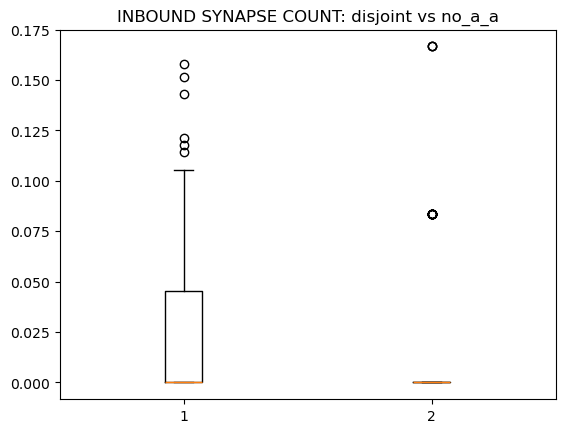

In [13]:
# Inbound Statistical tests

print('\n\nINBOUND SYNAPSE COUNT')

for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
            result = stats.ranksums(list(S_in[c1.__name__].values()), list(S_in[c2.__name__].values()), alternative='greater')
            if result.pvalue < 0.05:
                print('Greater:')
                print(result)
                plt.figure()
                plt.boxplot([list(S_in[c1.__name__].values()), list(S_in[c2.__name__].values())])
                plt.title(f'INBOUND SYNAPSE COUNT: {c1.__name__} vs {c2.__name__}')



OUTBOUND NONZERO SYNAPSE COUNT

shared vs disjoint

shared vs shared_no_a

shared vs no_a_a
Greater:
RanksumsResult(statistic=2.29705164961342, pvalue=0.010807911750401323)



shared vs a_no_a

disjoint vs shared

disjoint vs shared_no_a

disjoint vs no_a_a
Greater:
RanksumsResult(statistic=1.922681277982208, pvalue=0.027260044747799316)

disjoint vs a_no_a

shared_no_a vs shared

shared_no_a vs disjoint

shared_no_a vs no_a_a
Greater:
RanksumsResult(statistic=1.9595917942265424, pvalue=0.025021760624352553)

shared_no_a vs a_no_a
Greater:
RanksumsResult(statistic=2.3120239067653574, pvalue=0.010388182949702217)

no_a_a vs shared

no_a_a vs disjoint

no_a_a vs shared_no_a

no_a_a vs a_no_a

a_no_a vs shared

a_no_a vs disjoint

a_no_a vs shared_no_a

a_no_a vs no_a_a
Greater:
RanksumsResult(statistic=2.1608897344483924, pvalue=0.015351929036690085)


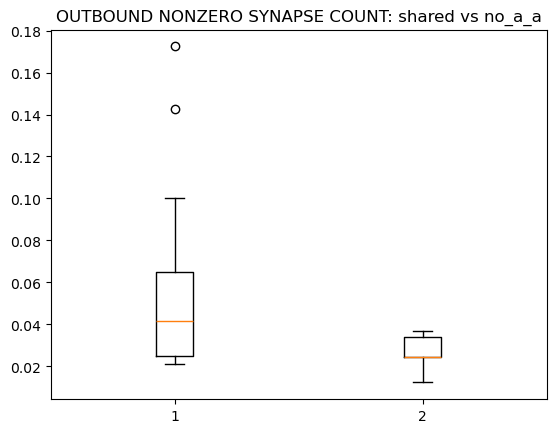

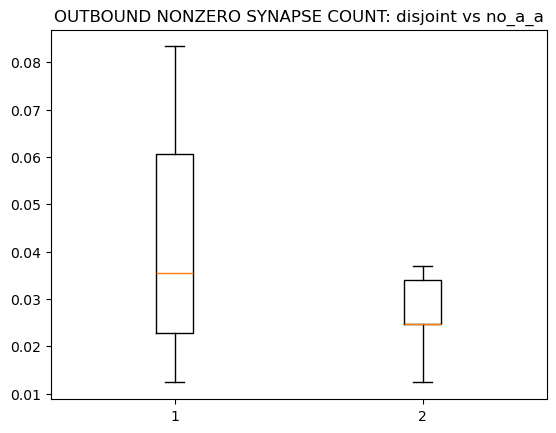

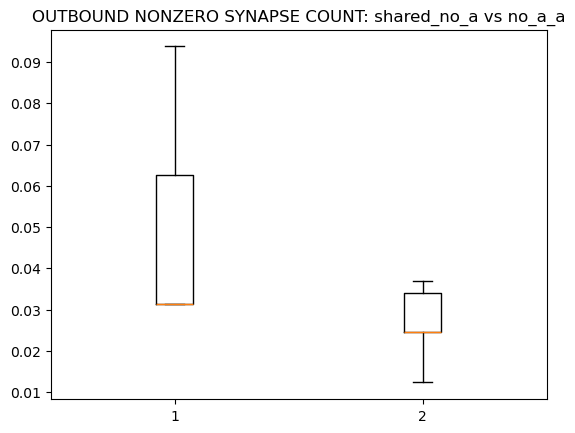

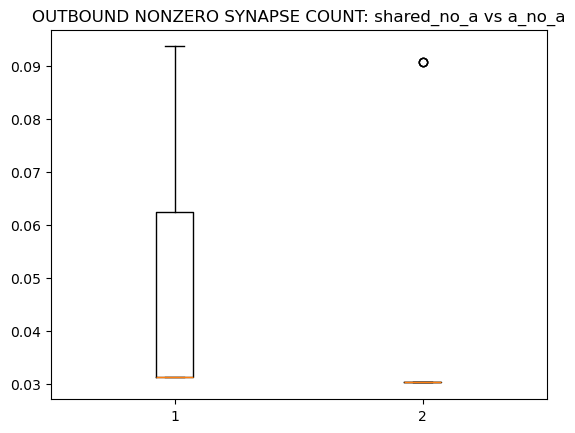

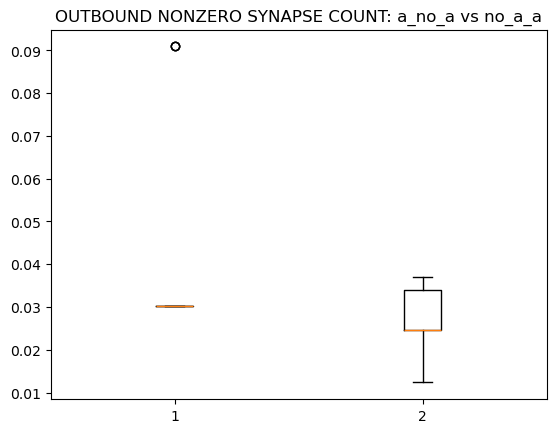

In [14]:
## Outbound Nonzero Synapse Count

print('\n\nOUTBOUND NONZERO SYNAPSE COUNT')

for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
            c1_set = np.array(list(S_out[c1.__name__].values()))[np.array(list(S_out[c1.__name__].values())).nonzero()[0]]
            c2_set = np.array(list(S_out[c2.__name__].values()))[np.array(list(S_out[c2.__name__].values())).nonzero()[0]]
            result = stats.ranksums(c1_set, c2_set, alternative='greater')
            if result.pvalue < 0.05:
                print('Greater:')
                print(result)
                plt.figure()
                plt.boxplot([c1_set, c2_set])
                plt.title(f'OUTBOUND NONZERO SYNAPSE COUNT: {c1.__name__} vs {c2.__name__}')
          



In [15]:
## Log10 (summed PSD)

print('\n\nSUMMED OUTBOUND LOG10(SUMMED PSDS)')
# Excluding values which require log10(0)
log_W_out = {k: {j: np.log10(v) for j, v in W_out[k].items() if v > 0} for k in W_out}
log_W_in = {k: {i: np.log10(v) for i, v in W_in[k].items() if v > 0} for k in W_in}

for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
            result = stats.ttest_ind(list(log_W_out[c1.__name__].values()), list(log_W_out[c2.__name__].values()), alternative='greater')
            if result.pvalue < 0.05:
                print('Greater:')
                print(result)
                print('Nonzero Counts:', np.count_nonzero(list(log_W_out[c1.__name__].values())), np.count_nonzero(list(log_W_out[c2.__name__].values())))
                print('Zero Counts:', len(list(log_W_out[c1.__name__].values())) - np.count_nonzero(list(log_W_out[c1.__name__].values())), len(list(log_W_out[c2.__name__].values())) - np.count_nonzero(list(log_W_out[c2.__name__].values())))
                plt.figure()
                plt.boxplot([list(W_out[c1.__name__].values()), list(W_out[c2.__name__].values())])
                plt.title(f'SUMMED OUTBOUND LOG10(SUMMED PSDS): {c1.__name__} vs {c2.__name__}')




SUMMED OUTBOUND LOG10(SUMMED PSDS)

shared vs disjoint

shared vs shared_no_a

shared vs no_a_a

shared vs a_no_a

disjoint vs shared

disjoint vs shared_no_a

disjoint vs no_a_a

disjoint vs a_no_a

shared_no_a vs shared

shared_no_a vs disjoint

shared_no_a vs no_a_a

shared_no_a vs a_no_a

no_a_a vs shared

no_a_a vs disjoint

no_a_a vs shared_no_a

no_a_a vs a_no_a

a_no_a vs shared

a_no_a vs disjoint

a_no_a vs shared_no_a

a_no_a vs no_a_a


100%|██████████| 15/15 [00:00<00:00, 282.87it/s]



DOWNSTREAM vs OTHER SUMMED OUTBOUND SUMMED PSDS

Downstream vs shared
Greater:
RanksumsResult(statistic=-1.4925382034959034, pvalue=0.9322209450971666)
[0.0, 0.0, 0.0, 99.8125, 0.0, 23.8, 0.0, 21.733333333333334, 0.0, 168.3, 0.0, 0.0, 0.0, 0.0, 80.77777777777777, 0.0, 224.7, 323.1666666666667, 0.0, 231.13333333333333, 39.107142857142854, 0.0, 13.176470588235293, 0.0, 10.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 359.6875, 0.0, 18.3, 248.3125, 0.0, 48.0, 0.0, 96.42857142857143, 0.0, 0.0, 0.0, 0.0, 71.72222222222223, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 398.06666666666666, 0.0]
[0.0, 120.3, 0.0, 0.0, 0.0, 38.48936170212766, 154.5, 0.0, 0.0, 8.25531914893617, 83.26086956521739, 0.0, 0.0, 118.0925925925926, 418.0, 0.0, 0.0, 53.36363636363637, 0.0, 0.0, 0.0, 0.0, 93.90243902439025, 0.0, 4.076923076923077, 0.0, 19.22, 134.43333333333334, 12.444444444444445, 0.0, 439.41379310344826, 73.76595744680851, 0.0, 49.425, 129.74074074074073, 55.608695652173914, 103.85365853658537, 0.0, 427.666666666

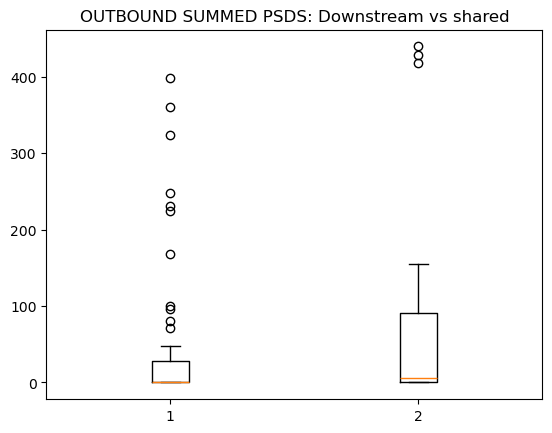

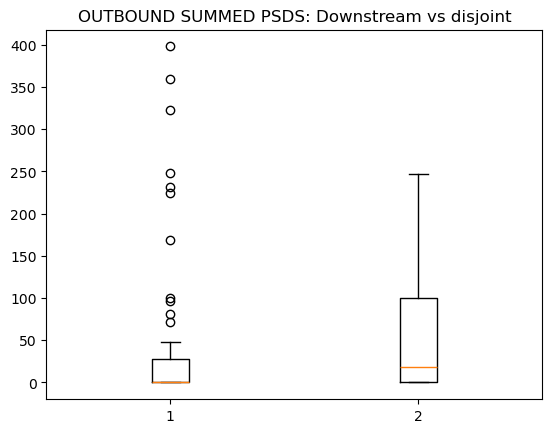

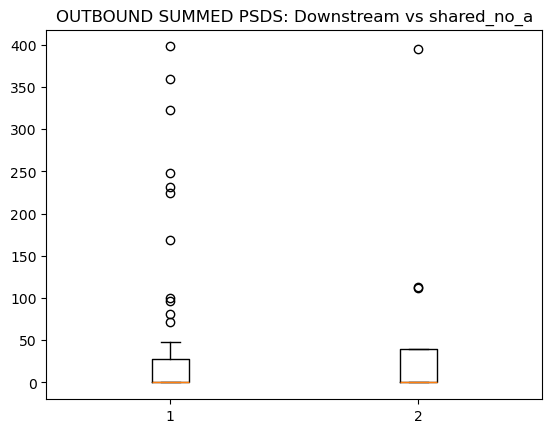

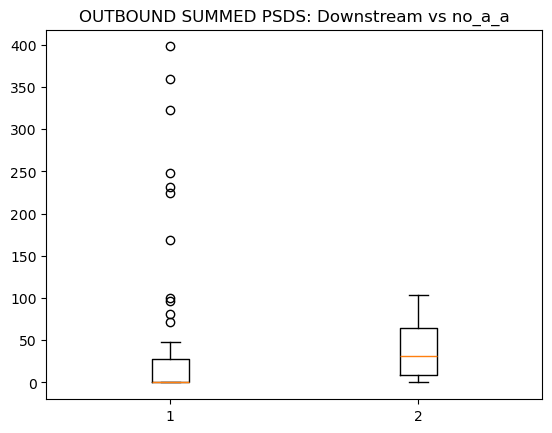

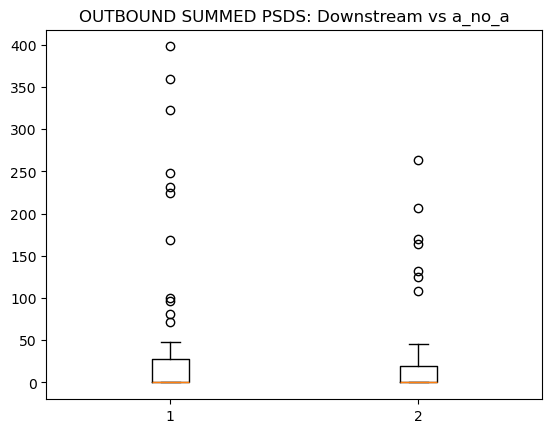

In [16]:
### Downstream analysis

patterns = data_a['functional']['sgc_assemblies']['assembly_pattern_detection']['activityPatterns'].item()
# print(patterns)

### Get the indexes of the activity patterns that correspond to the assembly activations
activity_pattern_indexes = data_a['functional']['sgc_assemblies']['assembly_pattern_detection']['assemblyIActivityPatterns'].item()

pt_root_ids_by_assembly_and_pattern = {}
# print(data_a['functional']['sgc_assemblies'])

for assembly_index in tqdm(range(len(activity_pattern_indexes))):
    # print(assembly_index)
    pt_root_ids_by_assembly_and_pattern[assembly_index] = {}
    for pattern_index in activity_pattern_indexes[assembly_index]:
        # print(pattern_index)
        pt_root_ids_by_assembly_and_pattern[assembly_index][pattern_index] = set()
        pattern = data_a['functional']['sgc_assemblies']['assembly_pattern_detection']['activityPatterns'].item()[pattern_index]
        for functional_index in pattern.nonzero()[0]:
            roi = mappings_a['functional_index_to_roi_id'][functional_index]
            try:
                # print(functional_index, mappings_a['roi_id_to_pt_root_id'][roi])
                root_id = mappings_a['roi_id_to_pt_root_id'][roi]
                if root_id in all_root_ids:
                    pt_root_ids_by_assembly_and_pattern[assembly_index][pattern_index].add(root_id)
            except KeyError:
                pass



# downstream_W_out = {}

# for c in C:
#     downstream_W_out[c.__name__] = {}
#     for assembly_index in pt_root_ids_by_assembly_and_pattern.keys():
#         pattern_indexes = list(pt_root_ids_by_assembly_and_pattern[assembly_index].keys())
#         for step in range(len(pattern_indexes) - 1):
#             pattern_index = pattern_indexes[step]
#             subsequent_pattern_index = pattern_indexes[step + 1]
#             downstream_W_out[c.__name__][pattern_index] = {}
#             for pre_root_id in pt_root_ids_by_assembly_and_pattern[assembly_index][pattern_index]:
#                 outbound_sum = 0
#                 for post_root_id in pt_root_ids_by_assembly_and_pattern[assembly_index][subsequent_pattern_index]:
#                     if (pre_root_id, post_root_id) in W_out:
#                         outbound_sum += W_out[(pre_root_id, post_root_id)]
#                 if outbound_sum > 0:
#                     print(outbound_sum)
#                 downstream_W_out[c.__name__][pattern_index][pre_root_id] = outbound_sum



downstream_W_out = {}
# for c in C:
#     print(c.__name__)
downstream_W_out = {}
for assembly_index in pt_root_ids_by_assembly_and_pattern.keys():
    # print(assembly_index)
    pattern_indexes = list(pt_root_ids_by_assembly_and_pattern[assembly_index].keys())
    for step in range(len(pattern_indexes) - 1):
        pattern_index = pattern_indexes[step]
        subsequent_pattern_index = pattern_indexes[step + 1]
        for j in pt_root_ids_by_assembly_and_pattern[assembly_index][pattern_index]:
            if j in pre_root_ids:
                outbound_sum = 0
                downstream_root_ids = [id for id in pt_root_ids_by_assembly_and_pattern[assembly_index][subsequent_pattern_index] if id in post_root_ids]
                if len([i for i in downstream_root_ids]) > 0:
                    downstream_W_out[j] = sum([w[(j, i)] for i in downstream_root_ids]) / len([i for i in downstream_root_ids])
                    # print(downstream_W_out[j])

print('\n\nDOWNSTREAM vs OTHER SUMMED OUTBOUND SUMMED PSDS')
for c2 in C:
    print(f'\nDownstream vs {c2.__name__}')
    result = stats.ranksums(list(downstream_W_out.values()), list(W_out[c2.__name__].values()), alternative='greater')
    # if result.pvalue < 0.05:
    print('Greater:')
    print(result)
    plt.figure()
    # downstream = np.array(list(downstream_W_out.values()))[np.array(list(downstream_W_out.values())).nonzero()[0]]
    # other = np.array(list(W_out[c2.__name__].values()))[np.array(list(W_out[c2.__name__].values())).nonzero()[0]]
    downstream = list(downstream_W_out.values())
    other = list(W_out[c2.__name__].values())
    print(downstream)
    print(other)
    plt.boxplot([downstream, other])
    plt.title(f'OUTBOUND SUMMED PSDS: Downstream vs {c2.__name__}')
    

In [17]:
## Signed rank, for summed PSDs when connections are present (nonzeros)

